In [1]:
import multiprocessing
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio
import sys
from scipy.signal import hilbert
import h5py
import neurokit2 as nk
import pandas as pd
import antropy as ant
sys.path.insert(0, "C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions")
from MEG_pareidolia_utils import *
import PARAMS
from PARAMS import *

c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\antropy\fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [282]:
df = pd.read_csv("../Merged_dataframes/df_ALL_metadata_MEG_sub00to11_epo_long_DFA.csv")

In [548]:
variable = 'DFA_delta'

df['harmsim_rescale'] = df.groupby('participant')[variable].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# randomize all values of harmsim_rescale
shuffled = df.groupby('participant')['harmsim_rescale'].apply(lambda x: x.sample(frac=1)).reset_index(level=0, drop=True)

# Reset index of shuffled series to align with the DataFrame's index
shuffled.reset_index(drop=True, inplace=True)

# Assign the shuffled values back to df
#df['harmsim_rescale'] = shuffled
df['FD_rescale'] = df.groupby('participant')['FD'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Calculate the difference between 'FD_rescale' and 'hurst_rescale'
df['diff_rescale'] = (df['FD_rescale'] - df['harmsim_rescale'])

# Group by bloc, electrode, and trial, then calculate the mean of 'diff_rescale'
grouped_diff = df.groupby(['participant', 'bloc', 'electrodes', 'trials'])['diff_rescale'].mean().reset_index()

# Use the MEG_atlas dictionary to assign each electrode to a brain region
def map_electrode_to_region(electrode, atlas):
    for region, electrodes in atlas.items():
        if electrode in electrodes:
            return region
    return 'Unknown'

# Map electrodes to brain regions
grouped_diff['brain_region'] = grouped_diff['electrodes'].apply(lambda x: map_electrode_to_region(x, MEG_atlas))

# Average diff_rescale by brain region, participant, and trial
avg_diff_by_region = grouped_diff.groupby(['participant', 'brain_region', 'trials'])['diff_rescale'].mean().reset_index()

# Merge with original DataFrame to get 'n_obj' values
merged_df = pd.merge(avg_diff_by_region, df[['participant', 'trials', 'n_obj']], on=['participant', 'trials'])

In [270]:
df

,trials,electrodes,index,DiffEn,FI,Hjorth,KFD,PEn,PFD,RR,...,harm_fit,harmsim,subharm_tension,DAT,offset,exp,harmsim_rescale,FD_rescale,diff_rescale,REGION_CONTRAST
24,0,24,0,-28.350561,0.477454,1.824516,3.758681,0.999989,1.006025,0.205833,...,4,1.352153,0.075453,91.554412,-27.228321,0.760143,0.520039,0.750000,0.229961,Frontal
25,0,25,0,-28.219000,0.520168,2.016371,3.349970,0.999979,1.005358,0.165226,...,4,7.380746,0.120394,91.554412,-26.894654,0.920655,0.596340,0.750000,0.153660,Frontal
26,0,26,0,-28.058754,0.496523,1.928078,3.226847,1.000000,1.006003,0.188159,...,7,3.397573,0.081141,91.554412,-27.091072,0.735005,0.607531,0.750000,0.142469,Frontal
27,0,27,0,-28.165913,0.500778,1.886362,3.094018,1.000000,1.005785,0.186800,...,5,1.511230,0.097270,91.554412,-27.096111,0.742288,0.514391,0.750000,0.235609,Frontal
28,0,28,0,-28.394834,0.486911,1.855327,3.384832,0.999957,1.005681,0.196625,...,2,2.426630,0.091696,91.554412,-27.252036,0.743637,0.445638,0.750000,0.304362,Frontal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977041,51,181,0,-28.264773,0.661807,2.989432,3.005370,0.999997,1.003681,0.070978,...,6,3.381482,0.052840,91.399824,-26.695436,1.161884,0.502886,0.666667,0.163780,Frontal
977042,51,182,0,-28.173051,0.708854,3.497183,2.880108,0.999928,1.002856,0.050247,...,4,4.581272,0.090770,91.399824,-26.548614,1.258678,0.515436,0.666667,0.151230,Frontal
977043,51,183,0,-28.138386,0.718518,3.627625,2.921304,0.999763,1.003007,0.046502,...,5,19.298833,0.044744,91.399824,-26.567974,1.250841,0.487540,0.666667,0.179126,Frontal
977044,51,184,0,-28.072720,0.676973,3.191207,2.989915,0.999937,1.003531,0.063318,...,5,2.967815,0.090669,91.399824,-26.699599,1.080101,0.500017,0.666667,0.166650,Frontal


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_11872\2024468168.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


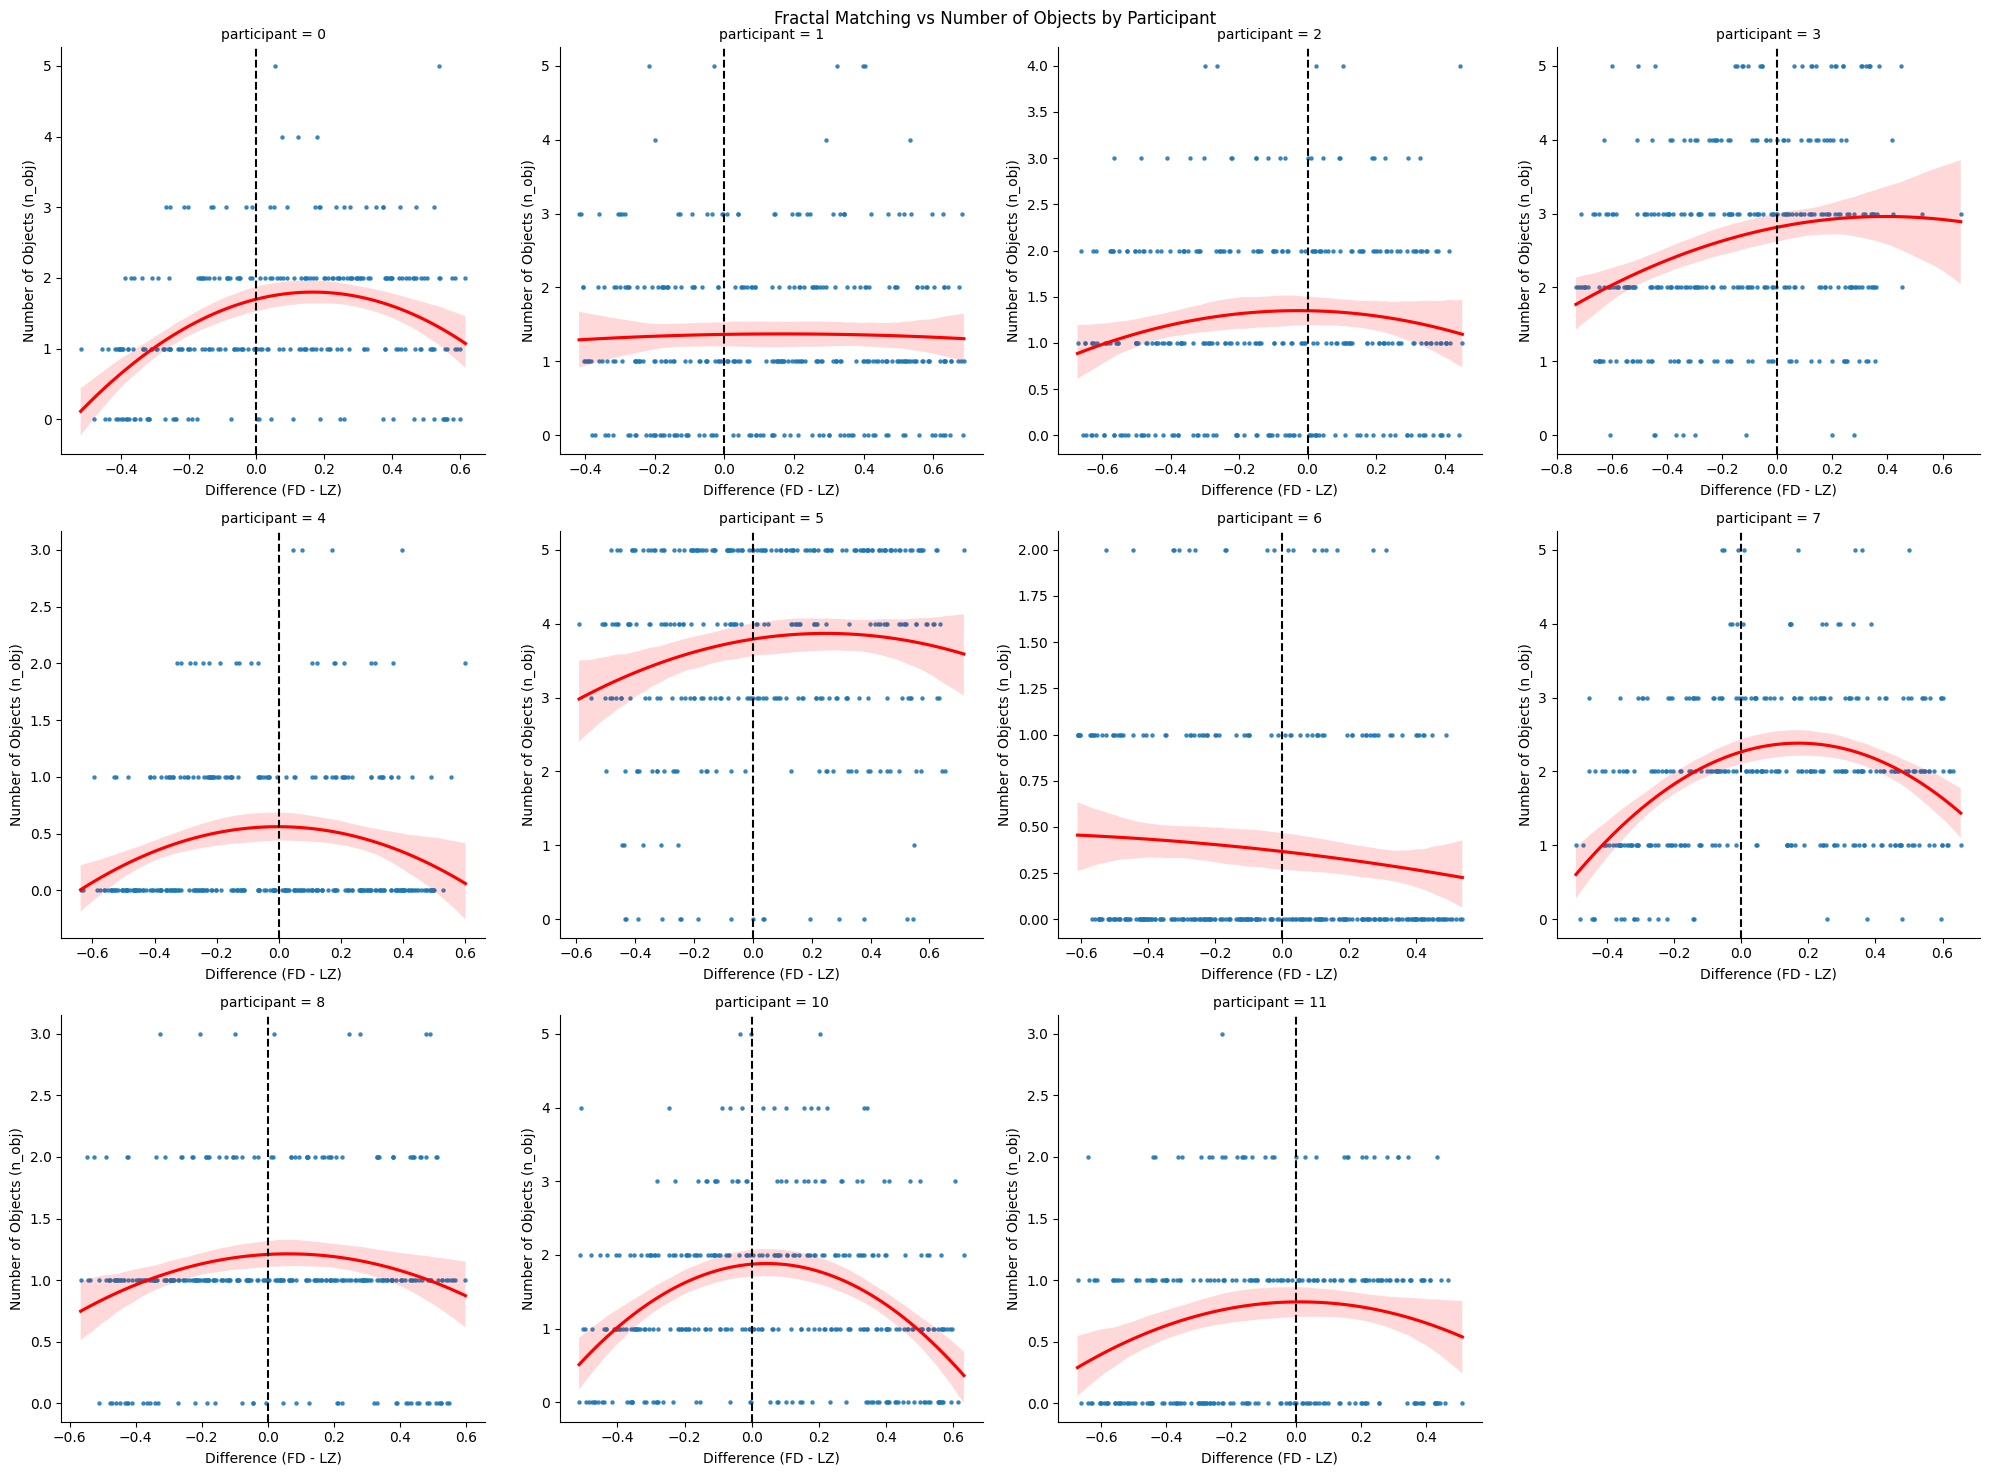

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
 
frontal_indices = MEG_atlas['FL'] + MEG_atlas['FR']
occipital_indices = MEG_atlas['OL'] + MEG_atlas['OR']
temporal_indices = MEG_atlas['TL'] + MEG_atlas['TR']

#keep occipital indices
#df = df[df['electrodes'].isin(occipital_indices)]
df['REGION_CONTRAST'] = df['electrodes'].apply(lambda x: 'Frontal' if x in frontal_indices else 'Occipital' if x in occipital_indices else 'Temporal' if x in temporal_indices else 'Unknown')

# keep only frontal electrodes
df_ = df[df['electrodes'].isin(occipital_indices)]

#df_ = df.copy()

# keep when column contrast=0

# Average across electrodes
df_ = df_.groupby(['participant', 'bloc', 'trials', 'n_obj', 'FD', 'contrast', 'DAT'])['diff_rescale'].mean().reset_index()
# remove rows when n_obj = 0
#df_ = df_[df_['n_obj'] != 0]
# Create a FacetGrid
g = sns.FacetGrid(df_, col='participant', col_wrap=4, height=5, sharex=False, sharey=False)

# Map a scatter plot with a quadratic regression line to each subplot
g.map(sns.regplot, 'diff_rescale', 'n_obj', order=2, scatter_kws={'s': 5}, line_kws={'color': 'red'})

# Add titles and labels
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in `g`
g.fig.suptitle('Fractal Matching vs Number of Objects by Participant')

# For each axis in the grid, set the labels and legend
for ax in g.axes.flatten():
    ax.set_xlabel('Difference (FD - LZ)')
    ax.set_ylabel('Number of Objects (n_obj)')

# add black vertical line when x = 0
for ax in g.axes.flatten():
    ax.axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
# Show the plot
#plt.savefig('Fractal_matching_all_participants_lz.png')
plt.show()


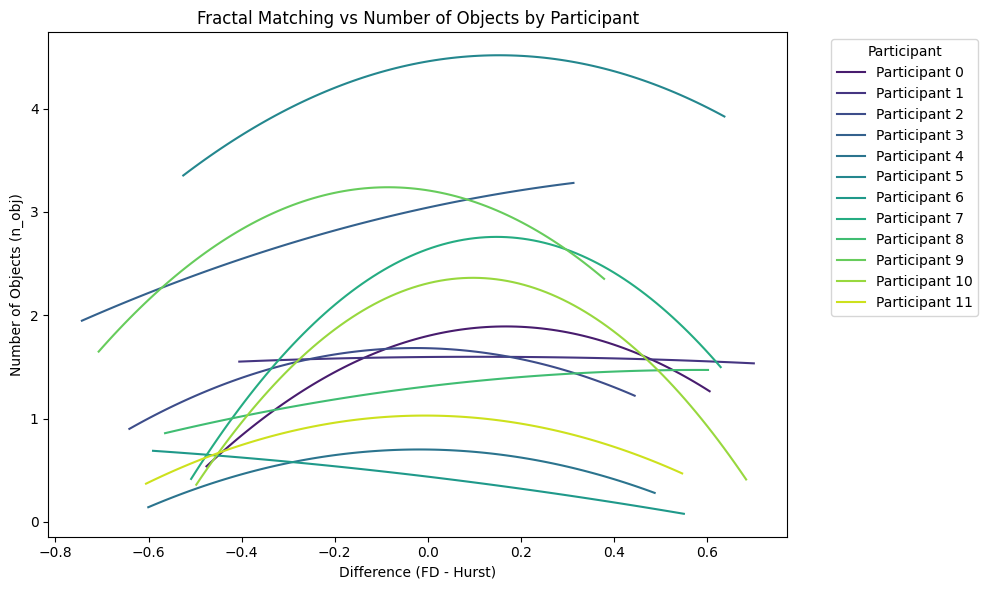

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming df_ is your DataFrame after preprocessing

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Get unique participants
participants = df_['participant'].unique()

# Generate a color palette with Seaborn, could be any palette or you can define your own
colors = sns.color_palette('viridis', n_colors=len(participants))

for i, participant in enumerate(participants):
    # Filter the DataFrame for the current participant
    participant_data = df_[df_['participant'] == participant]

    # Fit the quadratic regression
    coeffs = np.polyfit(participant_data['diff_rescale'], participant_data['n_obj'], 2)

    # Generate a range of x values for plotting the regression line
    x_vals = np.linspace(participant_data['diff_rescale'].min(), participant_data['diff_rescale'].max(), 100)

    # Calculate the y values using the coefficients from the polynomial fit
    y_vals = np.polyval(coeffs, x_vals)

    # Plot the regression line
    plt.plot(x_vals, y_vals, label=f'Participant {participant}', color=colors[i])

# Add title and labels
plt.title('Fractal Matching vs Number of Objects by Participant')
plt.xlabel('Difference (FD - Hurst)')
plt.ylabel('Number of Objects (n_obj)')

# Add legend
plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig('Fractal_matching_all_participants_single_contrast0.png')
plt.show()


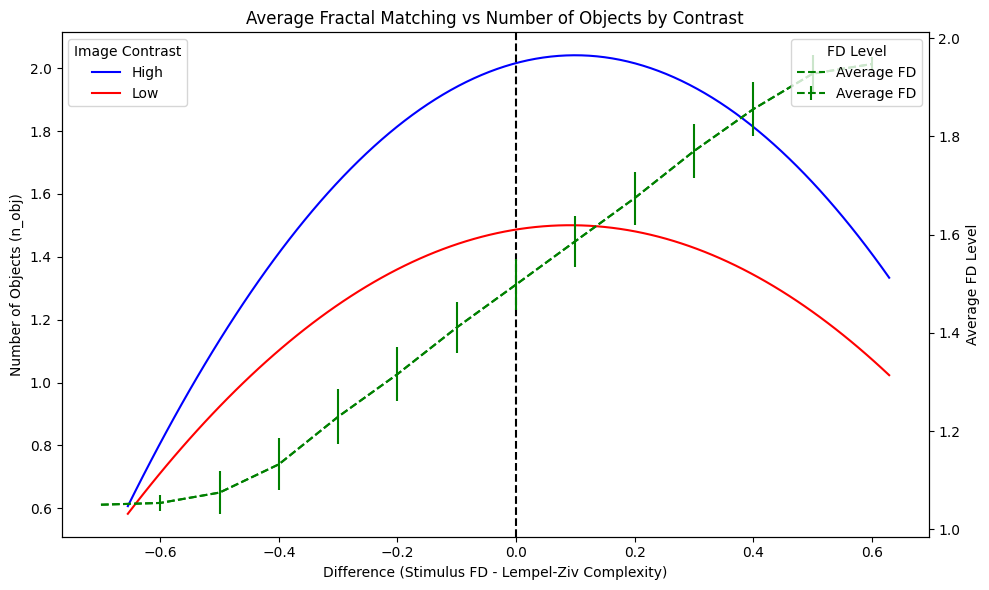

In [321]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit

df_ = df.copy()

# keep when column contrast=0

# Average across electrodes
df_ = df_.groupby(['participant', 'bloc', 'trials', 'n_obj', 'FD', 'contrast', 'DAT'])['diff_rescale'].mean().reset_index()
# remove rows when n_obj = 0
#df_ = df_[df_['n_obj'] != 0]
# Function to calculate the quadratic formula, which we will use to fit the curve
def quadratic_formula(x, a, b, c):
    return a * x**2 + b * x + c

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Initialize lists to store coefficients for each contrast condition
coeffs_contrast_0 = []
coeffs_contrast_1 = []

# Process data for each participant
for participant in participants:
    for contrast in [0, 1]:
        # Filter the DataFrame for the current participant and contrast
        participant_data = df_[(df_['participant'] == participant) & (df_['contrast'] == contrast)]

        # Skip participants with insufficient data
        if participant_data.shape[0] < 3:
            continue

        # Fit the quadratic regression
        coeffs, _ = curve_fit(quadratic_formula, participant_data['diff_rescale'], participant_data['n_obj'])

        # Store coefficients based on contrast
        if contrast == 0:
            coeffs_contrast_0.append(coeffs)
        else:
            coeffs_contrast_1.append(coeffs)

# Calculate average coefficients for each contrast condition
avg_coeffs_contrast_0 = np.mean(coeffs_contrast_0, axis=0)
avg_coeffs_contrast_1 = np.mean(coeffs_contrast_1, axis=0)

# Generate a range of x values for plotting the average regression lines
x_vals = np.linspace(df_['diff_rescale'].min(), df_['diff_rescale'].max(), 100)

# Calculate the y values using the average coefficients for contrast 0
y_vals_contrast_0 = quadratic_formula(x_vals, *avg_coeffs_contrast_0)

# Calculate the y values using the average coefficients for contrast 1
y_vals_contrast_1 = quadratic_formula(x_vals, *avg_coeffs_contrast_1)

# Plot the average regression line for contrast 0
plt.plot(x_vals, y_vals_contrast_0, label='High', color='blue')

# Plot the average regression line for contrast 1
plt.plot(x_vals, y_vals_contrast_1, label='Low', color='red')

# Add title and labels
plt.title('Average Fractal Matching vs Number of Objects by Contrast')
plt.xlabel('Difference (Stimulus FD - Lempel-Ziv Complexity)')
plt.ylabel('Number of Objects (n_obj)')

# Add black vertical line when x = 0
plt.axvline(x=0, color='black', linestyle='--')
# Add legend
plt.legend(title='Image Contrast', loc='upper left')

# Define bins for diff_rescale
bins = np.arange(-0.75, 0.75, 0.1)  # Adjust the bin ranges as needed
df_['diff_rescale_bins'] = pd.cut(df_['diff_rescale'], bins)

# Calculate average FD level for each bin
avg_fd_by_bin = df_.groupby('diff_rescale_bins')['FD'].mean()
std_fd_by_bin = df_.groupby('diff_rescale_bins')['FD'].std()

# Create a twin axis
ax2 = plt.gca().twinx()

# Plot the average FD level on the twin axis for each bin with standard deviation
ax2.errorbar(avg_fd_by_bin.index.categories.mid, avg_fd_by_bin.values, yerr=std_fd_by_bin.values, label='Average FD', color='green', linestyle='--')
ax2.plot(avg_fd_by_bin.index.categories.mid, avg_fd_by_bin.values, label='Average FD', color='green', linestyle='--')

# Add label for the second y-axis
ax2.set_ylabel('Average FD Level')

# Adjust x-axis to show bin ranges
#plt.xticks(ticks=np.arange(-0.75, 0.75, 0.1), labels=[f'{bin.left:.1f} to {bin.right:.1f}' for bin in avg_fd_by_bin.index.categories])

# Add legend for the second plot
ax2.legend(title='FD Level', loc='upper right')

# Show the plot with both y-axes
plt.tight_layout()
plt.show()

In [161]:
df_

,participant,n_obj,FD,trials,bloc,contrast,DAT,diff_rescale,abs_diff_rescale
0,0,0.0,1.050,3,2,1.0,91.554412,-0.480377,0.480377
1,0,0.0,1.050,11,5,0.0,91.554412,-0.439881,0.439881
2,0,0.0,1.050,16,2,0.0,91.554412,-0.457972,0.457972
3,0,0.0,1.050,16,3,1.0,91.554412,-0.426540,0.426540
4,0,0.0,1.050,29,3,1.0,91.554412,-0.400142,0.400142
...,...,...,...,...,...,...,...,...,...
3302,11,2.0,1.875,39,2,0.0,91.399824,0.347969,0.347969
3303,11,2.0,1.875,47,6,1.0,91.399824,0.387158,0.387158
3304,11,2.0,1.950,0,5,1.0,91.399824,0.479515,0.479515
3305,11,2.0,1.950,17,6,1.0,91.399824,0.449243,0.449243


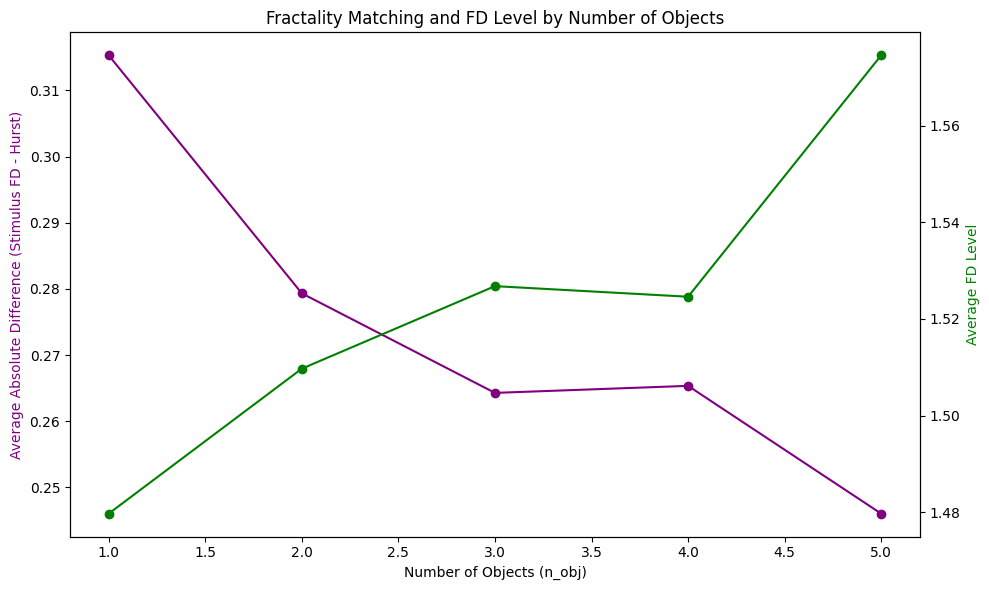

In [559]:
import matplotlib.pyplot as plt
import pandas as pd

# ... [Your existing code, if needed, before the plot] ...
df_ = df.copy()
frontal_indices = MEG_atlas['FL'] + MEG_atlas['FR']
occipital_indices = MEG_atlas['OL'] + MEG_atlas['OR']
temporal_indices = MEG_atlas['TL'] + MEG_atlas['TR']

#keep occipital indices
#df = df[df['electrodes'].isin(occipital_indices)]
df['REGION_CONTRAST'] = df['electrodes'].apply(lambda x: 'Frontal' if x in frontal_indices else 'Occipital' if x in occipital_indices else 'Temporal' if x in temporal_indices else 'Unknown')

# keep only frontal electrodes
#df_ = df[df['electrodes'].isin(occipital_indices)]
#remove rows when n_obj = 0

df_ = df.copy()
df_ = df_[df_['n_obj'] != 0]
df_ = df_.groupby(['participant', 'n_obj', 'FD', 'trials', 'bloc', 'contrast', 'DAT'])['diff_rescale'].mean().reset_index()
# Sum abosulte value of diff_rescale across n_obj
df_['abs_diff_rescale'] = df_['diff_rescale'].abs()
sum_abs_diff_by_n_obj = df_.groupby('n_obj')['abs_diff_rescale'].sum()
avg_abs_diff_by_n_obj = df_.groupby('n_obj')['abs_diff_rescale'].mean()
avg_diff_by_n_obj = df_.groupby('n_obj')['diff_rescale'].mean()

# Set up the matplotlib figure
ax1 = plt.figure(figsize=(10, 6)).gca()

# Plot the average diff_rescale for each n_obj
plt.plot(avg_abs_diff_by_n_obj.index, avg_abs_diff_by_n_obj.values, marker='o', linestyle='-', color='purple')
# add standard error of the mean
#plt.errorbar(avg_abs_diff_by_n_obj.index, avg_abs_diff_by_n_obj.values, yerr=std_abs_diff_by_n_obj.values, color='purple')

# Plot avg FD for each n_obj on a second y-axis
ax2 = plt.gca().twinx()
avg_FD = df_.groupby('n_obj')['FD'].mean()
std_FD = df_.groupby('n_obj')['FD'].std()
ax2.plot(avg_FD.index, avg_FD.values, marker='o', linestyle='-', color='green')
# add standard error of the mean
#ax2.errorbar(avg_FD.index, avg_FD.values, yerr=std_FD.values, color='green')

# Add title and labels
plt.title('Fractality Matching and FD Level by Number of Objects')

ax1.set_ylabel('Average Absolute Difference (Stimulus FD - Hurst)', color='purple')
ax2.set_ylabel('Average FD Level', color='green')
ax1.set_xlabel('Number of Objects (n_obj)')



# Show the plot
plt.tight_layout()
plt.show()


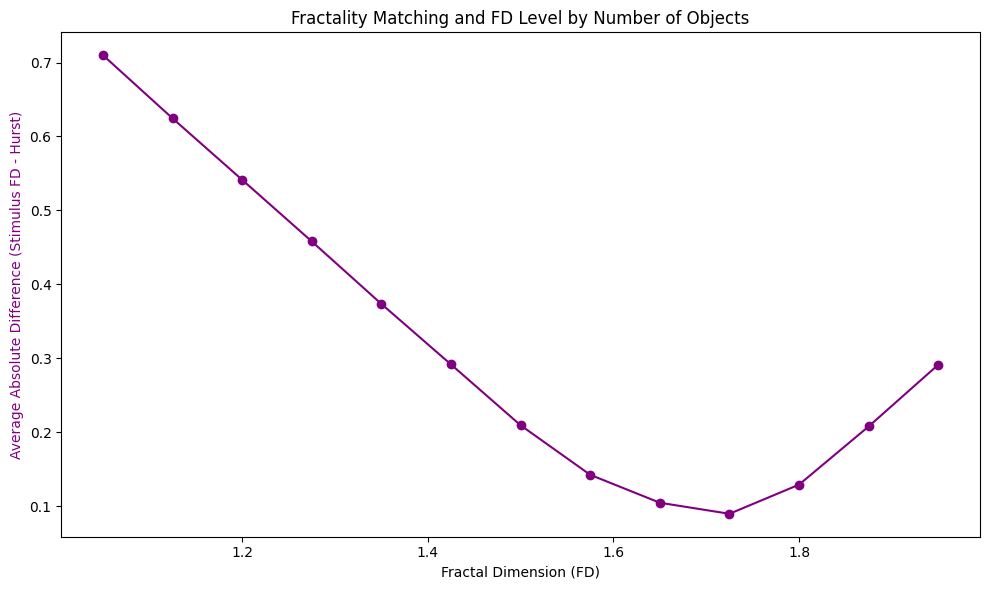

In [488]:
import matplotlib.pyplot as plt
import pandas as pd
var_ = 'FD'

df_ = df.copy()
df_ = df_[df_[var_] != 0]
df_ = df_.groupby(['participant', 'n_obj', 'FD', 'trials', 'bloc', 'contrast', 'DAT'])['diff_rescale'].mean().reset_index()
# Sum abosulte value of diff_rescale across n_obj
df_['abs_diff_rescale'] = df_['diff_rescale'].abs()
sum_abs_diff_by_n_obj = df_.groupby(var_)['abs_diff_rescale'].sum()
avg_abs_diff_by_n_obj = df_.groupby(var_)['abs_diff_rescale'].mean()
avg_diff_by_n_obj = df_.groupby(var_)['diff_rescale'].mean()

# Set up the matplotlib figure
ax1 = plt.figure(figsize=(10, 6)).gca()

# Plot the average diff_rescale for each n_obj
plt.plot(avg_abs_diff_by_n_obj.index, avg_abs_diff_by_n_obj.values, marker='o', linestyle='-', color='purple')
# add standard error of the mean
#plt.errorbar(avg_abs_diff_by_n_obj.index, avg_abs_diff_by_n_obj.values, yerr=std_abs_diff_by_n_obj.values, color='purple')


# add standard error of the mean
#ax2.errorbar(avg_FD.index, avg_FD.values, yerr=std_FD.values, color='green')

# Add title and labels
plt.title('Fractality Matching and FD Level by Number of Objects')

ax1.set_ylabel('Average Absolute Difference (Stimulus FD - Hurst)', color='purple')
ax1.set_xlabel('Fractal Dimension (FD)')



# Show the plot
plt.tight_layout()
plt.show()


(array([251., 231., 213., 243., 240., 255., 243., 225., 252., 233., 230.,
        203., 223., 155., 161.,  96.,  63.,  32.,  11.,   7.]),
 array([1.14506694e-04, 3.61135866e-02, 7.21126664e-02, 1.08111746e-01,
        1.44110826e-01, 1.80109906e-01, 2.16108986e-01, 2.52108066e-01,
        2.88107146e-01, 3.24106226e-01, 3.60105305e-01, 3.96104385e-01,
        4.32103465e-01, 4.68102545e-01, 5.04101625e-01, 5.40100705e-01,
        5.76099785e-01, 6.12098865e-01, 6.48097944e-01, 6.84097024e-01,
        7.20096104e-01]),
 <BarContainer object of 20 artists>)

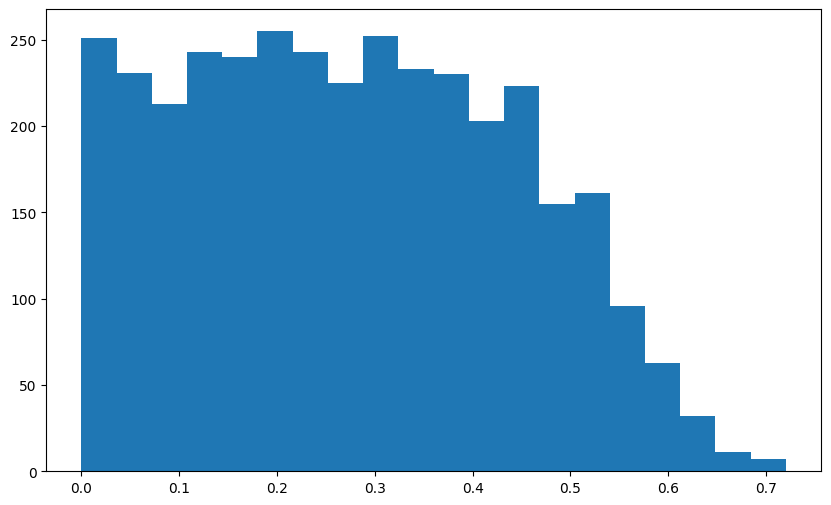

In [439]:
# plot histogram of diff_rescale
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot histogram of diff_rescale
plt.hist(df_['abs_diff_rescale'], bins=20)

In [560]:
import statsmodels.formula.api as smf
#df_ = df.copy()
#df_ = df_.groupby(['participant', 'n_obj', 'FD', 'trials', 'bloc', 'contrast', 'DAT'])['diff_rescale'].mean().reset_index()
# remove rows when n_obj = 0
df_ = df_[df_['n_obj'] != 0]
df_['abs_diff_rescale'] = df_['diff_rescale'].abs()

# create FD^2 column
df_['FD2'] = df_['FD']**2
# third model with interaction
model_formula_interaction = 'abs_diff_rescale ~ n_obj * (FD+FD2) + (1|participant)'
mixed_model_interaction = smf.mixedlm(model_formula_interaction, df_, groups=df_['participant'], re_formula="~FD+FD2")

mixed_model_result = mixed_model_interaction.fit()

# Print the summary of the mixed-effects model
print(mixed_model_result.summary())




c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_diff_rescale
No. Observations: 2687    Method:             REML            
No. Groups:       12      Scale:              0.0035          
Min. group size:  96      Log-Likelihood:     3739.6492       
Max. group size:  307     Converged:          Yes             
Mean group size:  223.9                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           4.687    0.085  55.272 0.000  4.521  4.853
n_obj               0.133    0.038   3.452 0.001  0.057  0.208
FD                 -5.581    0.120 -46.334 0.000 -5.817 -5.345
FD2                 1.709    0.047  36.047 0.000  1.617  1.802
n_obj:FD           -0.150    0.051  -2.912 0.004 -0.250 -0.049
n_obj:FD2           0.040    0.017   2.393 0.017  0.007  0.073
1 | p

c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [566]:
import statsmodels.formula.api as smf
#df_ = df.copy()
#df_ = df_.groupby(['participant', 'n_obj', 'FD', 'trials', 'bloc', 'contrast', 'DAT'])['diff_rescale'].mean().reset_index()
df_ = df.copy()
df_ = df_[df_['n_obj'] != 0]
df_ = df_.groupby(['participant', 'n_obj', 'FD', 'trials', 'bloc', 'contrast', 'DAT'])['LZ'].mean().reset_index()
# remove rows when n_obj = 0


# create FD^2 column
df_['FD2'] = df_['FD']**2
# third model with interaction
model_formula_interaction = 'LZ ~ n_obj * (FD) + (1|participant)'
mixed_model_interaction = smf.mixedlm(model_formula_interaction, df_, groups=df_['participant'])

mixed_model_result = mixed_model_interaction.fit()

# Print the summary of the mixed-effects model
print(mixed_model_result.summary())




          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  LZ       
No. Observations:  2687     Method:              REML     
No. Groups:        12       Scale:               0.0012   
Min. group size:   96       Log-Likelihood:      5203.3521
Max. group size:   307      Converged:           Yes      
Mean group size:   223.9                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.392    0.035 11.146 0.000  0.323  0.461
n_obj            0.002    0.003  0.722 0.470 -0.004  0.009
FD               0.001    0.005  0.274 0.784 -0.008  0.011
n_obj:FD        -0.002    0.002 -0.875 0.382 -0.006  0.002
1 | participant  0.001    0.005  0.148 0.882 -0.009  0.010
Group Var        0.003    0.046                           



c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


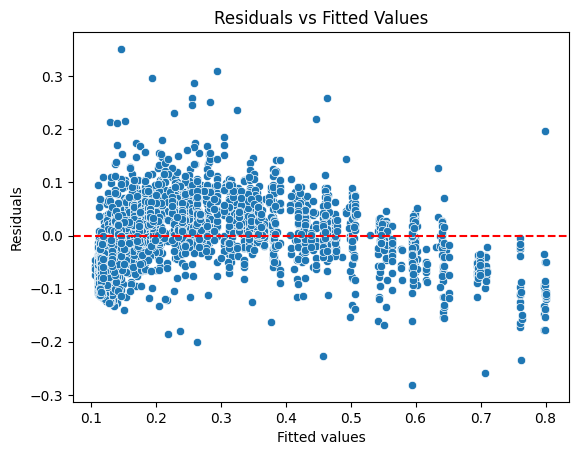

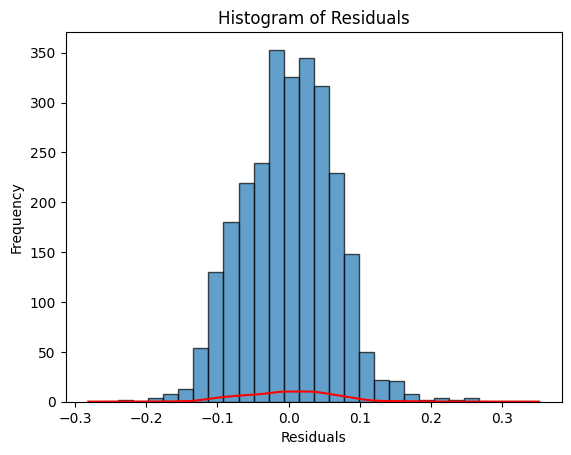

AttributeError: 'ScalarMappable' object has no attribute 'qqplot'

In [534]:
# Get the residuals
residuals = mixed_model_result.resid

# Plot the residuals
sns.scatterplot(x=mixed_model_result.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Plot the histogram of residuals using matplotlib's plt.hist
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# If you want to overlay a KDE
kde = stats.gaussian_kde(residuals)
x_range = np.linspace(min(residuals), max(residuals), 1000)
plt.plot(x_range, kde(x_range) * len(residuals) * (max(residuals) - min(residuals)) / 1000, color='red') # Scale KDE to match histogram
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print('Shapiro-Wilk test:', shapiro_test)


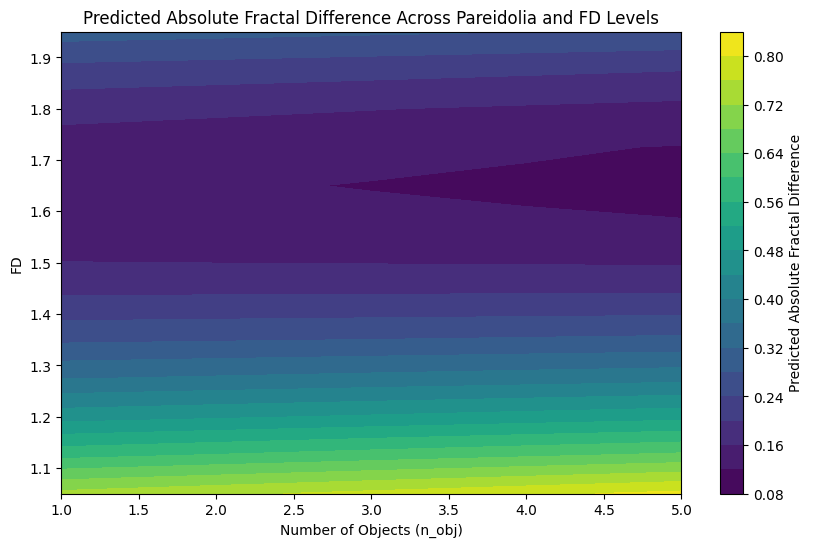

In [561]:
import numpy as np
import matplotlib.pyplot as plt

# Create a DataFrame for predictions that spans the range of n_obj and FD
n_obj_values = np.sort(df_['n_obj'].unique())
FD_values = np.sort(df_['FD'].unique())
pred_data = pd.DataFrame([(n, fd) for n in n_obj_values for fd in FD_values], columns=['n_obj', 'FD'])

pred_data['FD2'] = pred_data['FD']**2
# Add a representative participant column for the predictions
# (Here I'm just using the first participant as an example)
pred_data['participant'] = df_['participant'].iloc[1]

# Use the fitted model to generate predicted values
pred_data['predicted_abs_diff_rescale'] = mixed_model_result.predict(pred_data)

# Pivot the data for plotting, using keyword arguments
pivot_pred = pred_data.pivot(index='FD', columns='n_obj', values='predicted_abs_diff_rescale')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.contourf(n_obj_values, FD_values, pivot_pred, 20, cmap='viridis')
fig.colorbar(cax, ax=ax, label='Predicted Absolute Fractal Difference')

# Labeling
ax.set_title('Predicted Absolute Fractal Difference Across Pareidolia and FD Levels')
ax.set_xlabel('Number of Objects (n_obj)')
ax.set_ylabel('FD')



# Show the plot
plt.show()


C:\Users\Antoine\AppData\Local\Temp\ipykernel_11872\934587871.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='FD Level')


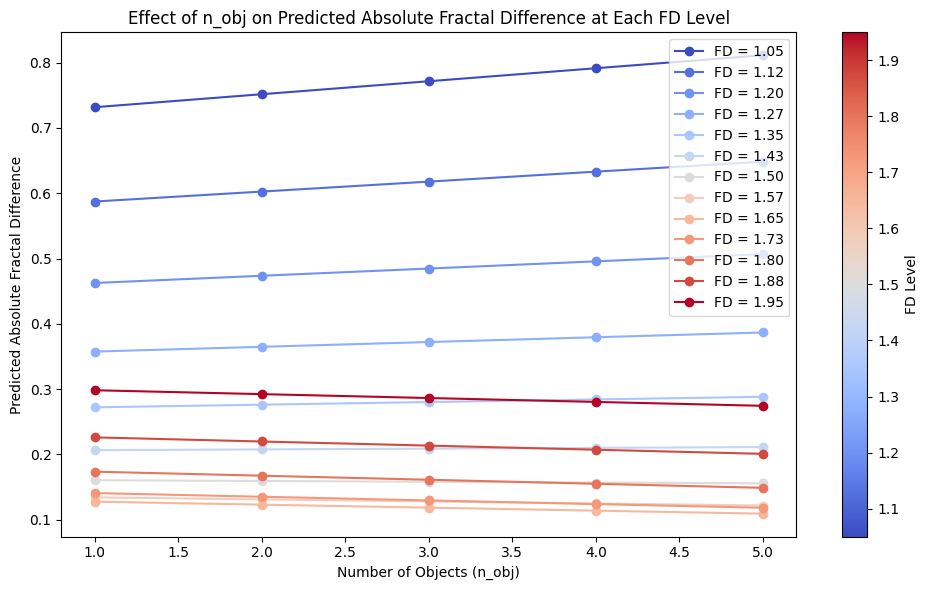

In [562]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a DataFrame for predictions that spans the range of n_obj
n_obj_values = np.sort(df_['n_obj'].unique())

# Get unique sorted FD values
fd_values = np.sort(df_['FD'].unique())

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a color map
cmap = cm.coolwarm

# Normalize FD values to the [0, 1] range for color mapping
norm = plt.Normalize(fd_values.min(), fd_values.max())

# Plot one line per FD level with colors from the 'coolwarm' colormap
for fd in fd_values:
    # Create a DataFrame for this FD level across all n_obj values
    pred_data_fd = pd.DataFrame({'n_obj': n_obj_values, 'FD': fd, 'FD2': fd**2})
    
    # Add a representative participant column for the predictions
    pred_data_fd['participant'] = df_['participant'].iloc[0]

    # Use the fitted model to generate predicted values for this FD level
    pred_data_fd['predicted_abs_diff_rescale'] = mixed_model_result.predict(pred_data_fd)

    # Get the color for this FD level
    color = cmap(norm(fd))

    # Plotting
    plt.plot(pred_data_fd['n_obj'], pred_data_fd['predicted_abs_diff_rescale'], marker='o', linestyle='-', label=f'FD = {fd:.2f}', color=color)

# Add a color bar to the side of the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older Matplotlib versions
plt.colorbar(sm, label='FD Level')

# Labeling
plt.title('Effect of n_obj on Predicted Absolute Fractal Difference at Each FD Level')
plt.xlabel('Number of Objects (n_obj)')
plt.ylabel('Predicted Absolute Fractal Difference')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [49]:
import statsmodels.genmod.bayes_mixed_glm as bmg
import numpy as np
import pandas as pd

# Prepare your data for the model
df_['diff_rescale_sq'] = df_['diff_rescale'] ** 2  # Quadratic term
endog = df_['n_obj']  # The dependent variable
exog = df_[['diff_rescale', 'diff_rescale_sq']]  # Fixed effects
exog_vc = pd.get_dummies(df_['participant'])  # Random effects one-hot encoding for participants
ident = np.arange(exog_vc.shape[1])  # Each column (participant) has a unique variance component

# Fit the Poisson mixed model with a Bayesian approach
model = bmg.PoissonBayesMixedGLM(endog, exog, exog_vc.values, ident)
result = model.fit_vb()  # Using variational Bayes

print(result.summary())


                  Poisson Mixed GLM Results
                Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------
diff_rescale       M     0.1649   0.0413                      
diff_rescale_sq    M    -0.8959   0.0882                      
VC_1               V    -0.2776   0.6396 0.758   0.211   2.722
VC_2               V    -0.3392   0.6563 0.712   0.192   2.647
VC_3               V    -0.4229   0.6813 0.655   0.168   2.559
VC_4               V     0.2584   0.5333 1.295   0.446   3.762
VC_5               V     0.0346   0.5708 1.035   0.331   3.242
VC_6               V     0.4154   0.5109 1.515   0.545   4.209
VC_7               V     0.1392   0.5523 1.149   0.381   3.469
VC_8               V     0.0260   0.5724 1.026   0.327   3.225
VC_9               V    -0.6440   0.7643 0.525   0.114   2.422
VC_10              V     0.2256   0.5383 1.253   0.427   3.677
VC_11              V    -0.2648   0.6362 0.767   0.215   2.739
VC_12      

In [90]:
import statsmodels.genmod.bayes_mixed_glm as bmg
import numpy as np
import pandas as pd

# Assuming 'contrast' is already in your df_ DataFrame as a binary variable
# Convert to int if it's not numeric
df_['contrast'] = df_['contrast'].astype(int)

# Add the quadratic term
df_['diff_rescale_sq'] = df_['diff_rescale'] ** 2

# Create the interaction term
df_['interaction'] = df_['diff_rescale_sq'] * df_['contrast']

# The dependent variable
endog = df_['n_obj']

# The fixed effects now include the interaction term
exog = df_[['diff_rescale', 'diff_rescale_sq', 'contrast', 'interaction']]

# Random effects one-hot encoding for participants
exog_vc = pd.get_dummies(df_['participant'])

# Each column (participant) has a unique variance component
ident = np.arange(exog_vc.shape[1])

# Fit the Poisson mixed model with a Bayesian approach
model = bmg.PoissonBayesMixedGLM(endog, exog, exog_vc.values, ident)
result = model.fit_vb()  # Using variational Bayes

# Print the summary of the model
print(result.summary())


                  Poisson Mixed GLM Results
                Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------
diff_rescale       M    -0.1249   0.0438                      
diff_rescale_sq    M    -1.3540   0.0887                      
contrast           M    -0.3076   0.0217                      
interaction        M     0.1220   0.1356                      
VC_1               V    -0.0856   0.5946 0.918   0.279   3.015
VC_2               V    -0.1291   0.6039 0.879   0.263   2.941
VC_3               V    -0.2217   0.6254 0.801   0.229   2.799
VC_4               V     0.3354   0.5219 1.399   0.492   3.972
VC_5               V    -0.1121   0.6002 0.894   0.269   2.969
VC_6               V     0.4964   0.5004 1.643   0.604   4.470
VC_7               V     0.0119   0.5751 1.012   0.320   3.197
VC_8               V     0.1615   0.5486 1.175   0.392   3.521
VC_9               V    -0.3209   0.6512 0.725   0.197   2.668
VC_10      

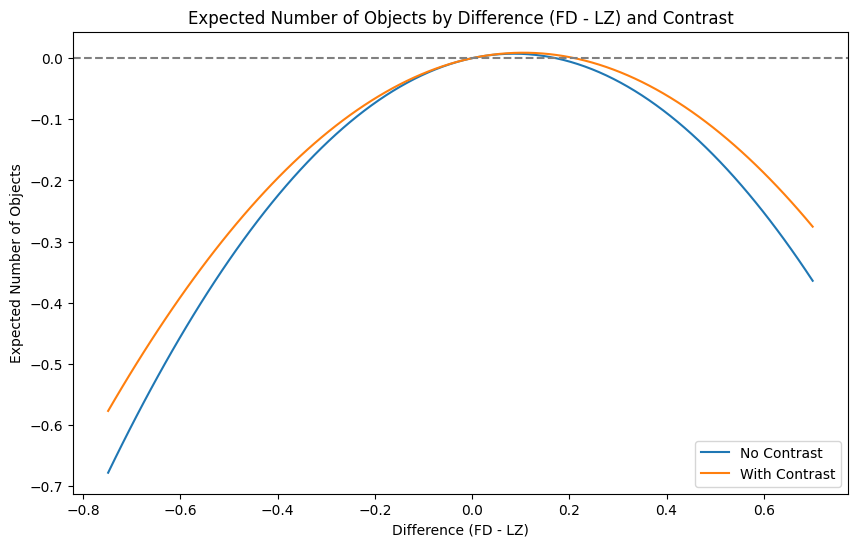

In [52]:
# Assuming `result` is the output of the model fitting process
params = result.params
# Assuming params is an array of parameter estimates in the order they appear in the model summary
diff_rescale_coef = params[0]
diff_rescale_sq_coef = params[1]
contrast_coef = params[2]
interaction_coef = params[3]

# Define a range for the difference (FD - LZ)
x = np.linspace(df_['diff_rescale'].min(), df_['diff_rescale'].max(), 100)

# Calculate the expected number of objects without contrast effect
y_no_contrast = (diff_rescale_coef * x +
                 diff_rescale_sq_coef * x**2)

# Calculate the expected number of objects with contrast effect
# Assuming contrast is a binary variable coded as 0 or 1
y_with_contrast = (diff_rescale_coef * x +
                   diff_rescale_sq_coef * x**2 +
                   contrast_coef * 0 +  # Change the 1 to the appropriate contrast level if needed
                   interaction_coef * x**2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y_no_contrast, label='No Contrast')
plt.plot(x, y_with_contrast, label='With Contrast')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Difference (FD - LZ)')
plt.ylabel('Expected Number of Objects')
plt.title('Expected Number of Objects by Difference (FD - LZ) and Contrast')
plt.legend()
plt.show()



In [14]:
# Extract the summary as a text string
summary_str = result.summary().as_text()

# Depending on the structure of your summary, you may need to process the text
# For example, split the summary text by line breaks and then by spaces
summary_lines = summary_str.split('\n')
clean_lines = [line.strip().split() for line in summary_lines if line.strip() != '']

# Now create a DataFrame from the cleaned lines
# You might need to adjust this part to match the exact format of your summary
summary_data = []
for line in clean_lines:
    if len(line) > 1:  # This checks if there are enough elements in the line to consider
        summary_data.append(line)

# Create a DataFrame
summary_df = pd.DataFrame(summary_data)

# If you know the specific rows and columns that are relevant, you can extract them
# For example, if the parameter estimates start at a certain row and span specific columns
# summary_df = summary_df.iloc[start_row:end_row, start_col:end_col]

# Now save the DataFrame to a CSV file
summary_df.to_csv('model_summary.csv', index=False)

# To ensure the file has been saved and to get the path for downloading
print("Summary saved to 'model_summary.csv'")


Summary saved to 'model_summary.csv'


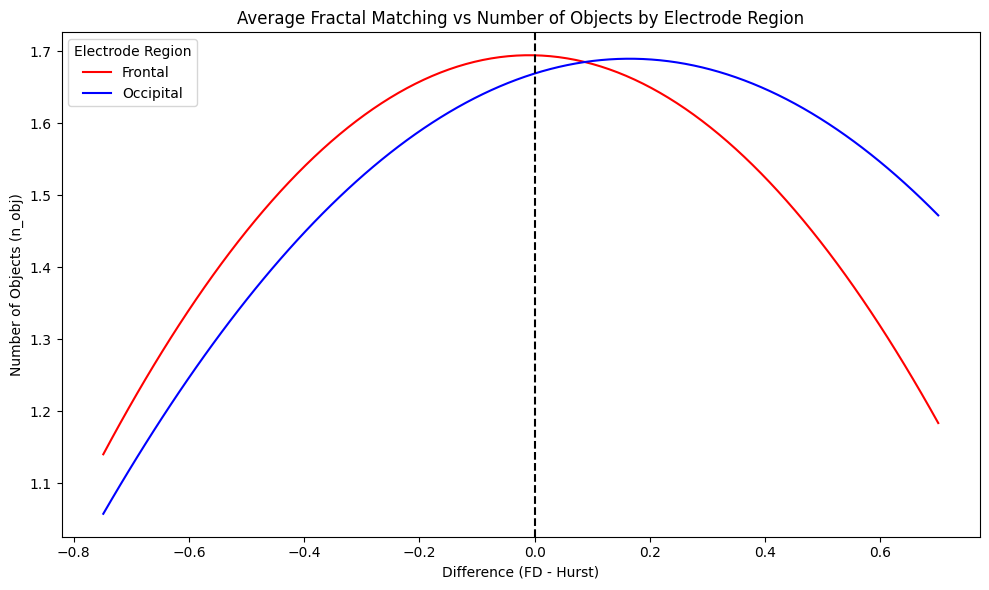

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Function to calculate the quadratic formula
def quadratic_formula(x, a, b, c):
    return a * x**2 + b * x + c

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Define electrode regions
frontal_indices = MEG_atlas['FL'] + MEG_atlas['FR']
occipital_indices = MEG_atlas['OL'] + MEG_atlas['OR']

# Initialize lists to store coefficients
coeffs_frontal = []
coeffs_occipital = []

# Process data for each electrode region
for region_indices, coeffs_list in zip([frontal_indices, occipital_indices], [coeffs_frontal, coeffs_occipital]):
    region_data = df[df['electrodes'].isin(region_indices)]
    # Fit the quadratic regression
    coeffs, _ = curve_fit(quadratic_formula, region_data['diff_rescale'], region_data['n_obj'])
    coeffs_list.append(coeffs)

# Calculate average coefficients for each electrode region
avg_coeffs_frontal = np.mean(coeffs_frontal, axis=0)
avg_coeffs_occipital = np.mean(coeffs_occipital, axis=0)

# Generate a range of x values for plotting the average regression lines
x_vals = np.linspace(df_['diff_rescale'].min(), df_['diff_rescale'].max(), 100)

# Calculate the y values using the average coefficients for frontal electrodes
y_vals_frontal = quadratic_formula(x_vals, *avg_coeffs_frontal)

# Calculate the y values using the average coefficients for occipital electrodes
y_vals_occipital = quadratic_formula(x_vals, *avg_coeffs_occipital)

# Plot the average regression line for frontal electrodes
plt.plot(x_vals, y_vals_frontal, label='Frontal', color='red')

# Plot the average regression line for occipital electrodes
plt.plot(x_vals, y_vals_occipital, label='Occipital', color='blue')

# Add title and labels
plt.title('Average Fractal Matching vs Number of Objects by Electrode Region')
plt.xlabel('Difference (FD - Hurst)')
plt.ylabel('Number of Objects (n_obj)')

# Add black vertical line when x = 0
plt.axvline(x=0, color='black', linestyle='--')

# Add legend
plt.legend(title='Electrode Region', loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig('Fractal_matching_average_curves_electrode_region.png')
plt.show()


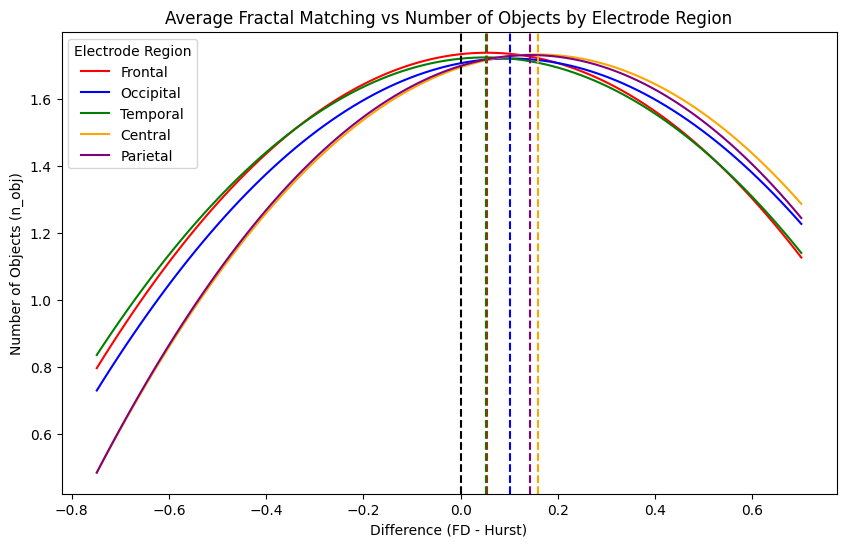

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Function to calculate the quadratic formula
def quadratic_formula(x, a, b, c):
    return a * x**2 + b * x + c

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Define electrode regions
frontal_indices = MEG_atlas['FL'] + MEG_atlas['FR']
occipital_indices = MEG_atlas['OL'] + MEG_atlas['OR']
temporal_indices = MEG_atlas['TL'] + MEG_atlas['TR']
central_indices = MEG_atlas['CL'] + MEG_atlas['CR']
parietal_indices = MEG_atlas['PL'] + MEG_atlas['PR']

# Initialize lists to store individual participant coefficients for each region
coeffs_individual_frontal = []
coeffs_individual_occipital = []
coeffs_individual_temporal = []
coeffs_individual_central = []
coeffs_individual_parietal = []

# Get unique participants
unique_participants = df['participant'].unique()

# Process data for each participant and electrode region
for participant in unique_participants:
    participant_frontal_data = df[(df['electrodes'].isin(frontal_indices)) & (df['participant'] == participant)]
    participant_occipital_data = df[(df['electrodes'].isin(occipital_indices)) & (df['participant'] == participant)]
    participant_temporal_data = df[(df['electrodes'].isin(temporal_indices)) & (df['participant'] == participant)]
    participant_central_data = df[(df['electrodes'].isin(central_indices)) & (df['participant'] == participant)]
    participant_parietal_data = df[(df['electrodes'].isin(parietal_indices)) & (df['participant'] == participant)]
    
    # Skip participants with insufficient data
    if participant_frontal_data.shape[0] < 3 or participant_occipital_data.shape[0] < 3:
        continue
    
    # Fit the quadratic regression for frontal and occipital data
    coeffs_frontal, _ = curve_fit(quadratic_formula, participant_frontal_data['diff_rescale'], participant_frontal_data['n_obj'])
    coeffs_occipital, _ = curve_fit(quadratic_formula, participant_occipital_data['diff_rescale'], participant_occipital_data['n_obj'])
    coeffs_temporal, _ = curve_fit(quadratic_formula, participant_temporal_data['diff_rescale'], participant_temporal_data['n_obj'])
    coeffs_central, _ = curve_fit(quadratic_formula, participant_central_data['diff_rescale'], participant_central_data['n_obj'])
    coeffs_parietal, _ = curve_fit(quadratic_formula, participant_parietal_data['diff_rescale'], participant_parietal_data['n_obj'])
    
    coeffs_individual_frontal.append(coeffs_frontal)
    coeffs_individual_occipital.append(coeffs_occipital)
    coeffs_individual_temporal.append(coeffs_temporal)
    coeffs_individual_central.append(coeffs_central)
    coeffs_individual_parietal.append(coeffs_parietal)

# Calculate average coefficients for each electrode region
avg_coeffs_frontal = np.mean(coeffs_individual_frontal, axis=0)
avg_coeffs_occipital = np.mean(coeffs_individual_occipital, axis=0)
avg_coeffs_temporal = np.mean(coeffs_individual_temporal, axis=0)
avg_coeffs_central = np.mean(coeffs_individual_central, axis=0)
avg_coeffs_parietal = np.mean(coeffs_individual_parietal, axis=0)

# Generate a range of x values for plotting the average regression lines
x_vals = np.linspace(df_['diff_rescale'].min(), df_['diff_rescale'].max(), 100)

# Calculate the y values using the average coefficients for frontal electrodes
y_vals_frontal = quadratic_formula(x_vals, *avg_coeffs_frontal)

# Calculate the y values using the average coefficients for occipital electrodes
y_vals_occipital = quadratic_formula(x_vals, *avg_coeffs_occipital)

# Calculate the y values using the average coefficients for temporal electrodes
y_vals_temporal = quadratic_formula(x_vals, *avg_coeffs_temporal)

# Calculate the y values using the average coefficients for central electrodes
y_vals_central = quadratic_formula(x_vals, *avg_coeffs_central)

# Calculate the y values using the average coefficients for parietal electrodes
y_vals_parietal = quadratic_formula(x_vals, *avg_coeffs_parietal)

# Plot the average regression line for frontal electrodes
plt.plot(x_vals, y_vals_frontal, label='Frontal', color='red')
plt.plot(x_vals, y_vals_occipital, label='Occipital', color='blue')
plt.plot(x_vals, y_vals_temporal, label='Temporal', color='green')
plt.plot(x_vals, y_vals_central, label='Central', color='orange')
plt.plot(x_vals, y_vals_parietal, label='Parietal', color='purple')


# Add title and labels
plt.title('Average Fractal Matching vs Number of Objects by Electrode Region')
plt.xlabel('Difference (FD - Hurst)')
plt.ylabel('Number of Objects (n_obj)')
plt.legend(title='Electrode Region', loc='upper left')

# Add black vertical line when x = 0
plt.axvline(x=0, color='black', linestyle='--')

# Add red vertical line when Frontal line is at its peak
plt.axvline(x=-avg_coeffs_frontal[1] / (2 * avg_coeffs_frontal[0]), color='red', linestyle='--')

# Add blue vertical line when Occipital line is at its peak
plt.axvline(x=-avg_coeffs_occipital[1] / (2 * avg_coeffs_occipital[0]), color='blue', linestyle='--')
plt.axvline(x=-avg_coeffs_temporal[1] / (2 * avg_coeffs_temporal[0]), color='green', linestyle='--')
plt.axvline(x=-avg_coeffs_central[1] / (2 * avg_coeffs_central[0]), color='orange', linestyle='--')
plt.axvline(x=-avg_coeffs_parietal[1] / (2 * avg_coeffs_parietal[0]), color='purple', linestyle='--')

C:\Users\Antoine\AppData\Local\Temp\ipykernel_11872\777791146.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_dat_df['n_obj_normalized'] = (low_dat_df['n_obj'] - low_dat_df['n_obj'].mean()) / low_dat_df['n_obj'].std()
C:\Users\Antoine\AppData\Local\Temp\ipykernel_11872\777791146.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_dat_df['n_obj_normalized'] = (high_dat_df['n_obj'] - high_dat_df['n_obj'].mean()) / high_dat_df['n_obj'].std()


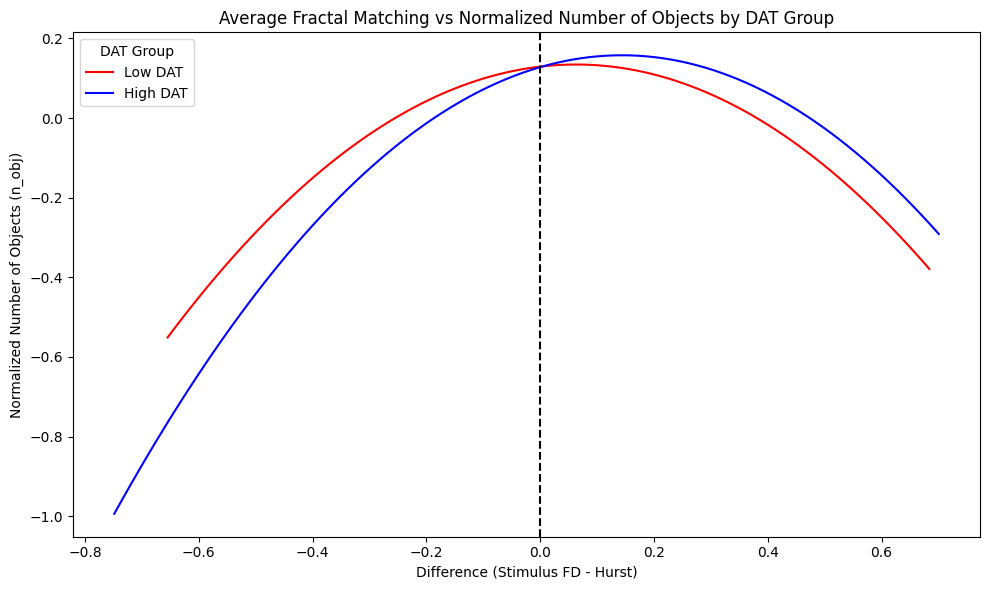

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import pandas as pd

# Assuming df_ is your DataFrame and it contains 'DAT' and 'n_obj' columns

# Function to calculate the quadratic formula
def quadratic_formula(x, a, b, c):
    return a * x ** 2 + b * x + c

# Median split based on DAT
median_dat = df_['DAT'].median()
low_dat_df = df_[df_['DAT'] < median_dat]
high_dat_df = df_[df_['DAT'] >= median_dat]

# Normalize n_obj for both groups
low_dat_df['n_obj_normalized'] = (low_dat_df['n_obj'] - low_dat_df['n_obj'].mean()) / low_dat_df['n_obj'].std()
high_dat_df['n_obj_normalized'] = (high_dat_df['n_obj'] - high_dat_df['n_obj'].mean()) / high_dat_df['n_obj'].std()

# Function to process and plot data for each group
def process_and_plot(df, label, color):
    coeffs = []
    for participant in df['participant'].unique():
        participant_data = df[df['participant'] == participant]
        if participant_data.shape[0] < 3:
            continue
        coeffs_, _ = curve_fit(quadratic_formula, participant_data['diff_rescale'], participant_data['n_obj_normalized'])
        coeffs.append(coeffs_)
    avg_coeffs = np.mean(coeffs, axis=0)
    x_vals = np.linspace(df['diff_rescale'].min(), df['diff_rescale'].max(), 100)
    y_vals = quadratic_formula(x_vals, *avg_coeffs)
    plt.plot(x_vals, y_vals, label=label, color=color)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Process and plot data for low and high DAT groups
process_and_plot(low_dat_df, 'Low DAT', 'red')
process_and_plot(high_dat_df, 'High DAT', 'blue')

# Add title, labels, and other plot elements
plt.title('Average Fractal Matching vs Normalized Number of Objects by DAT Group')
plt.xlabel('Difference (Stimulus FD - Hurst)')
plt.ylabel('Normalized Number of Objects (n_obj)')
plt.axvline(x=0, color='black', linestyle='--')
plt.legend(title='DAT Group', loc='upper left')
plt.tight_layout()
plt.savefig('Fractal_matching_average_curves_hurst_normalized.png')
plt.show()


In [66]:
import statsmodels.genmod.bayes_mixed_glm as bmg
import numpy as np
import pandas as pd

# Assuming 'DAT' is already in your df_ DataFrame as a numeric variable
# If it's not numeric, convert it
#df_['DAT'] = pd.to_numeric(df_['DAT'], errors='coerce')

# normalize DAT
df_['DAT'] = (df_['DAT'] - df_['DAT'].mean()) / df_['DAT'].std()
# Add the quadratic term
df_['diff_rescale_sq'] = df_['diff_rescale'] ** 2

# Create the new interaction term with DAT instead of contrast
df_['interaction_DAT'] = df_['diff_rescale_sq'] * df_['DAT']

# The dependent variable
endog = df_['n_obj']

# The fixed effects now include the new interaction term with DAT
exog = df_[['diff_rescale', 'diff_rescale_sq', 'DAT', 'interaction_DAT']]

# Random effects one-hot encoding for participants
exog_vc = pd.get_dummies(df_['participant'])

# Each column (participant) has a unique variance component
ident = np.arange(exog_vc.shape[1])

# Fit the Poisson mixed model with a Bayesian approach
model = bmg.PoissonBayesMixedGLM(endog, exog, exog_vc.values, ident)
result = model.fit_vb()  # Using variational Bayes

# Print the summary of the model
print(result.summary())


                  Poisson Mixed GLM Results
                Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------
diff_rescale       M     0.2185   0.0448                      
diff_rescale_sq    M    -1.0488   0.0971                      
DAT                M    -0.2028   0.0176                      
interaction_DAT    M     0.2679   0.1227                      
VC_1               V    -0.0884   0.5952 0.915   0.278   3.010
VC_2               V    -0.2243   0.6261 0.799   0.228   2.795
VC_3               V    -0.8529   0.8790 0.426   0.073   2.472
VC_4               V     0.3555   0.5191 1.427   0.505   4.030
VC_5               V     0.2462   0.5351 1.279   0.439   3.730
VC_6               V     0.4272   0.5094 1.533   0.554   4.246
VC_7               V    -0.0166   0.5806 0.984   0.308   3.141
VC_8               V     0.0913   0.5605 1.096   0.357   3.361
VC_9               V    -0.9096   0.9203 0.403   0.064   2.537
VC_10      

In [ ]:
import statsmodels.genmod.bayes_mixed_glm as bmg
import numpy as np
import pandas as pd

# Assuming 'contrast' is already in your df_ DataFrame as a binary variable
# Convert to int if it's not numeric
df_['contrast'] = df_['contrast'].astype(int)

# Add the quadratic term
df_['diff_rescale_sq'] = df_['diff_rescale'] ** 2

# Create the interaction term
df_['interaction'] = df_['diff_rescale_sq'] * df_['contrast']

# The dependent variable
endog = df_['n_obj']

# The fixed effects now include the interaction term
exog = df_[['diff_rescale', 'diff_rescale_sq', 'contrast', 'interaction']]

# Random effects one-hot encoding for participants
exog_vc = pd.get_dummies(df_['participant'])

# Each column (participant) has a unique variance component
ident = np.arange(exog_vc.shape[1])

# Fit the Poisson mixed model with a Bayesian approach
model = bmg.PoissonBayesMixedGLM(endog, exog, exog_vc.values, ident)
result = model.fit_vb()  # Using variational Bayes

# Print the summary of the model
print(result.summary())


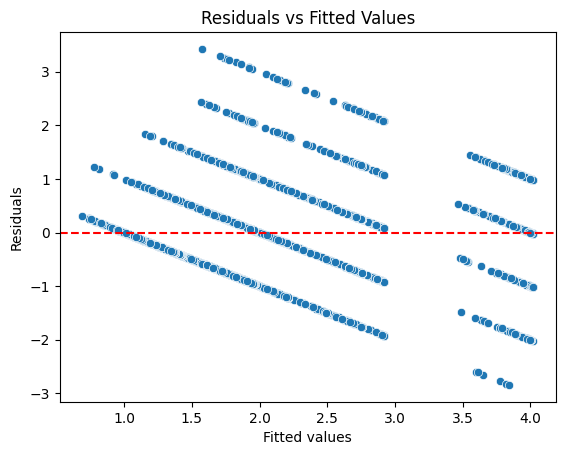

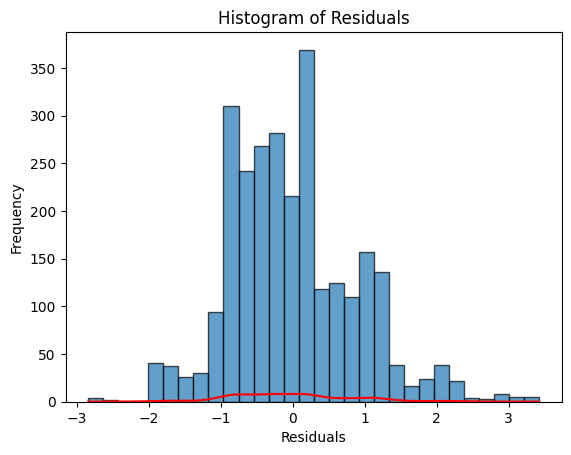

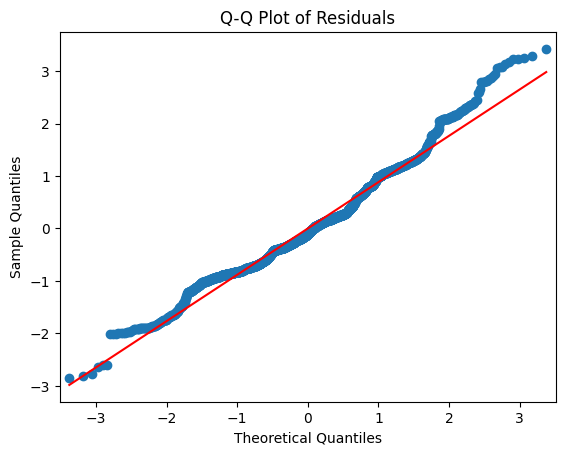

Shapiro-Wilk test: ShapiroResult(statistic=0.977769136428833, pvalue=3.020559866662485e-20)


In [230]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Fit the model as before
mixed_model = smf.mixedlm('n_obj ~ diff_rescale + diff_rescale_sq', df_, groups=df_['participant'], re_formula='~1')
mixed_result = mixed_model.fit()

# Get the residuals
residuals = mixed_result.resid

# Plot the residuals
sns.scatterplot(x=mixed_result.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Plot the histogram of residuals using matplotlib's plt.hist
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# If you want to overlay a KDE
kde = stats.gaussian_kde(residuals)
x_range = np.linspace(min(residuals), max(residuals), 1000)
plt.plot(x_range, kde(x_range) * len(residuals) * (max(residuals) - min(residuals)) / 1000, color='red') # Scale KDE to match histogram
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print('Shapiro-Wilk test:', shapiro_test)


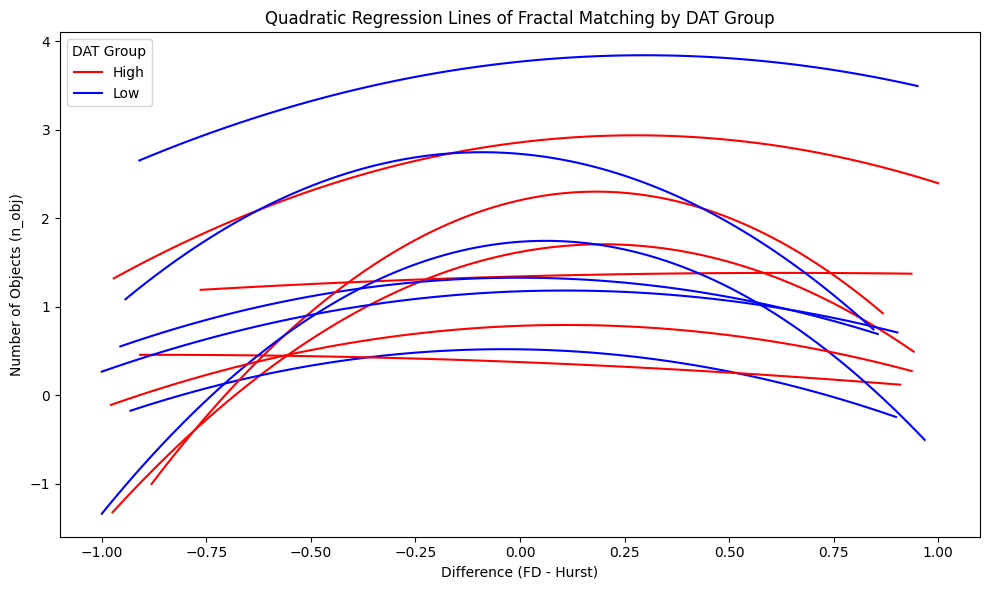

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the DAT groups based on your criteria
median_DAT = df['DAT'].median()
df['DAT_group'] = df['DAT'].apply(lambda x: 'High' if x >= median_DAT else 'Low')

# Set the color palette for the two groups
palette = {'High': 'red', 'Low': 'blue'}

# Plot the quadratic regression lines
plt.figure(figsize=(10, 6))

for participant in df['participant'].unique():
    # Filter data for the current participant
    participant_data = df[df['participant'] == participant]
    
    # Determine the DAT group for coloring
    dat_group = participant_data['DAT_group'].iloc[0]
    
    # Fit a quadratic regression model
    coeffs = np.polyfit(participant_data['diff_rescale'], participant_data['n_obj'], deg=2)
    
    # Create a range of x values for plotting the regression line
    x = np.linspace(participant_data['diff_rescale'].min(), participant_data['diff_rescale'].max(), num=100)
    
    # Calculate the y values based on the coefficients from the polynomial fit
    y = np.polyval(coeffs, x)
    
    # Plot the regression line
    plt.plot(x, y, color=palette[dat_group], label=dat_group if dat_group not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title('Quadratic Regression Lines of Fractal Matching by DAT Group')
plt.xlabel('Difference (FD - Hurst)')
plt.ylabel('Number of Objects (n_obj)')

# Create custom legends for the DAT groups
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='DAT Group')

plt.tight_layout()
plt.show()


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model for FD level 1.05 converged.
Model for FD level 1.125 converged.


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model for FD level 1.2 converged.
Model for FD level 1.275 converged.


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model for FD level 1.35 converged.
Model for FD level 1.425 converged.


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model for FD level 1.5 converged.
Model for FD level 1.575 converged.


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model for FD level 1.65 converged.
Model for FD level 1.725 converged.


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model for FD level 1.8 converged.
Model for FD level 1.875 converged.


c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\goofi\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Model for FD level 1.95 converged.


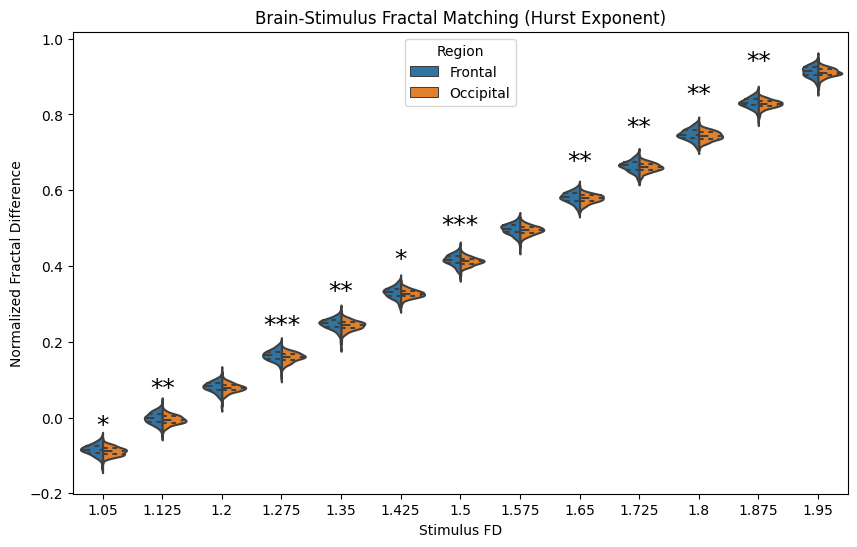

In [206]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


def perform_t_tests(avg_diff_subset, var):
    p_values = {}
    for fd_level in avg_diff_subset['FD'].unique():
        data0 = avg_diff_subset[(avg_diff_subset['FD'] == fd_level) & (avg_diff_subset[var] == 0)]['diff_rescale']
        data1 = avg_diff_subset[(avg_diff_subset['FD'] == fd_level) & (avg_diff_subset[var] == 1)]['diff_rescale']
        t_stat, p_val = ttest_ind(data0, data1, equal_var=False)
        p_values[fd_level] = p_val
    return p_values

import statsmodels.api as sm
import statsmodels.formula.api as smf

def perform_mixed_effects_model(avg_diff_subset, var):
    p_values = {}
    model_summaries = {}
    for fd_level in avg_diff_subset['FD'].unique():
        subset_df = avg_diff_subset[avg_diff_subset['FD'] == fd_level]

        # Define the model
        model = smf.mixedlm('diff_rescale ~ ' + var, subset_df, groups=subset_df['participant'], re_formula="~" + var)
        result = model.fit()

        # Store the p-value
        p_values[fd_level] = result.pvalues[var]

        # Store the model summary
        model_summaries[fd_level] = result.summary()

        # Check convergence
        if result.converged:
            print(f"Model for FD level {fd_level} converged.")
        else:
            print(f"Model for FD level {fd_level} did not converge.")

    return p_values, model_summaries

var = 'REGION_CONTRAST'
# Extracting indices for occipital channels
frontal_indices = MEG_atlas['FL'] + MEG_atlas['FR']
occipital_indices = MEG_atlas['OL'] + MEG_atlas['OR']
df['REGION_CONTRAST'] = df['electrodes'].apply(lambda x: 0 if x in frontal_indices else 1)
# Assuming your DataFrame 'df' has a column that specifies channel indices
# Filter the DataFrame to keep only occipital channels
#occipital_df = df[df['electrodes'].isin(occipital_indices)]

# Now perform the grouping and averaging on the filtered DataFrame
avg_diff_by_FD_parei_trials = df.groupby(['participant', 'FD', var, 'trials'])['diff_rescale'].mean().reset_index()

#avg_diff_by_FD_parei_trials = df.groupby(['participant', 'FD', var, 'trials'])['diff_rescale'].mean().reset_index()

def plot_violin_with_significance(participants_set, title_suffix, var):
    # Filter data for the current set of participants
    avg_diff_subset_trials = avg_diff_by_FD_parei_trials[avg_diff_by_FD_parei_trials['participant'].isin(participants_set)]
    # average across trials
    #avg_diff_subset_trials = avg_diff_subset_trials.groupby(['participant', 'FD', var])['diff_rescale'].mean().reset_index()
    # Perform t-tests and get p-values
    p_values = perform_t_tests(avg_diff_subset_trials, var)
    p_values, model_summaries = perform_mixed_effects_model(avg_diff_subset_trials, var)
    # Plotting
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    
    # Create the violin plot
    violin = sns.violinplot(data=avg_diff_subset_trials, x='FD', y='diff_rescale', hue=var, split=True, inner='quart', ax=ax)
    # Remove the existing legend
    handles, labels = ax.get_legend_handles_labels()
    
    # Define new handles and labels for the custom legend
    new_handles = [handles[0], handles[-1]]  # Assuming the first and last handles correspond to the groups
    new_labels = ['Frontal', 'Occipital']
    
    # Create the custom legend
    ax.legend(handles=new_handles, labels=new_labels, title='Region', loc='upper center')
    fd_levels = avg_diff_subset_trials['FD'].unique()
    fd_levels.sort()  # Sorting to ensure correct ordering

    # Calculate the max value for each FD level
    max_values = avg_diff_subset_trials.groupby('FD')['diff_rescale'].max()

    for i, fd_level in enumerate(fd_levels):
        # Check if p-value is significant and if so, add stars
        p = p_values[fd_level]
        stars = ''
        if p < 0.001:
            stars = "***"
        elif p < 0.01:
            stars = "**"
        elif p < 0.05:
            stars = "*"

        if stars:
            # Calculate position for the stars
            x_position = i
            max_value_fd_level = max_values[fd_level]
            
            # Place text above the highest point of the violin plot
            ax.text(x_position, max_value_fd_level + (max_value_fd_level * 0.05), stars, ha='center', va='bottom', color='black', fontsize=18)

    plt.title(f'Brain-Stimulus Fractal Matching ({title_suffix})')
    plt.xlabel('Stimulus FD')
    plt.ylabel('Normalized Fractal Difference')
    #plt.legend(title='Region', loc='upper left', labels=['Frontal', 'Occipital'])


all_participants = df['participant'].unique()
# Plot for high DAT participants with significance stars
plot_violin_with_significance(all_participants, 'Hurst Exponent', var)
#plt.savefig(f'Fractal_matching_pareidolia_occiVSfrontal_noabs_{variable}.png', dpi=300)

# Plot for low DAT participants with significance stars
#plot_violin_with_significance(low_DAT_participants, 'Low DAT Score', var)


In [65]:
from scipy.stats import ttest_ind

# Function to perform t-tests for each FD level within each DAT group
def perform_t_tests_by_FD_and_DAT(df, participants_set, group_name):
    results = []
    for fd_level in df['FD'].unique():
        parei_0_diff = df[(df['participant'].isin(participants_set)) & (df['FD'] == fd_level) & (df['parei'] == 0)]['diff_rescale']
        parei_1_diff = df[(df['participant'].isin(participants_set)) & (df['FD'] == fd_level) & (df['parei'] == 1)]['diff_rescale']

        t_stat, p_val = ttest_ind(parei_0_diff, parei_1_diff, equal_var=False)
        results.append({
            'DAT Group': group_name,
            'FD': fd_level,
            't-statistic': t_stat,
            'p-value': p_val
        })

    return pd.DataFrame(results)

new_df = df.groupby(['participant', 'FD', 'parei', 'trials'])['diff_rescale'].mean().reset_index()
# Running t-tests for both high and low DAT groups
t_test_results_high_DAT = perform_t_tests_by_FD_and_DAT(new_df, high_DAT_participants, 'High DAT')
t_test_results_low_DAT = perform_t_tests_by_FD_and_DAT(new_df, low_DAT_participants, 'Low DAT')

# Combine results
t_test_results = pd.concat([t_test_results_high_DAT, t_test_results_low_DAT]).reset_index(drop=True)
print(t_test_results)


   DAT Group     FD  t-statistic   p-value
0   High DAT  1.050    -2.849384  0.005170
1   High DAT  1.125    -0.695798  0.488043
2   High DAT  1.200    -2.627044  0.009741
3   High DAT  1.275    -0.533443  0.595051
4   High DAT  1.350     0.941306  0.348886
5   High DAT  1.425    -1.187044  0.237930
6   High DAT  1.500    -2.306284  0.023204
7   High DAT  1.575    -2.268381  0.028480
8   High DAT  1.650     0.608455  0.544769
9   High DAT  1.725     0.036051  0.971317
10  High DAT  1.800     0.611961  0.542411
11  High DAT  1.875     1.446328  0.151395
12  High DAT  1.950     1.827898  0.070064
13   Low DAT  1.050     0.763928  0.447019
14   Low DAT  1.125     2.412040  0.018628
15   Low DAT  1.200     1.407536  0.165026
16   Low DAT  1.275     2.428771  0.021572
17   Low DAT  1.350     3.225625  0.002632
18   Low DAT  1.425     0.747750  0.459559
19   Low DAT  1.500     1.733728  0.089991
20   Low DAT  1.575    -4.750664  0.000012
21   Low DAT  1.650    -3.076405  0.003541
22   Low DA

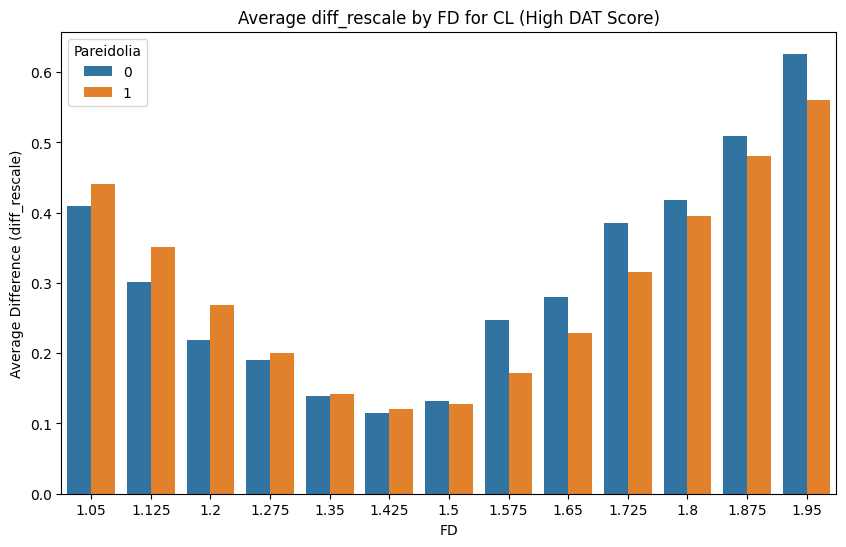

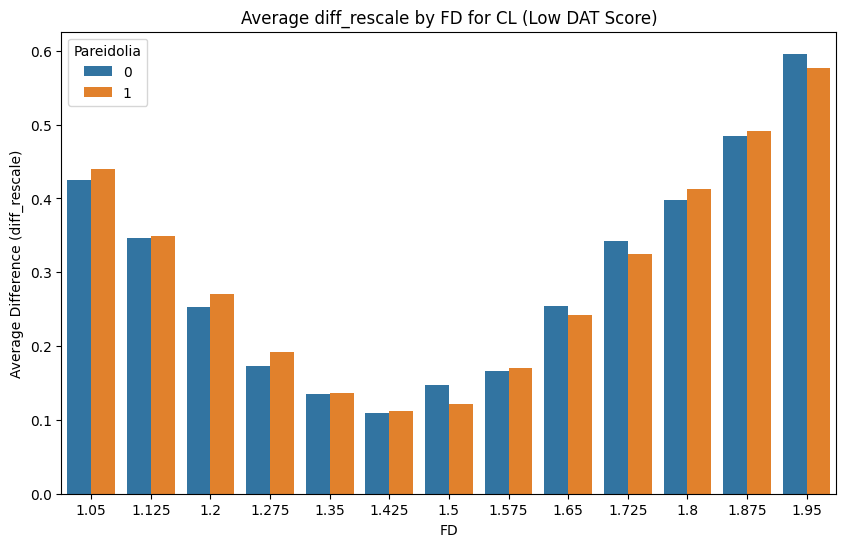

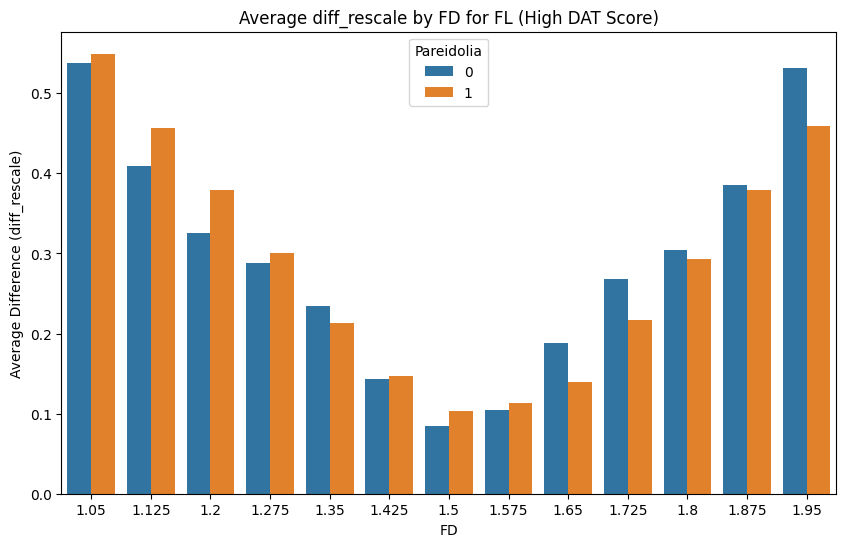

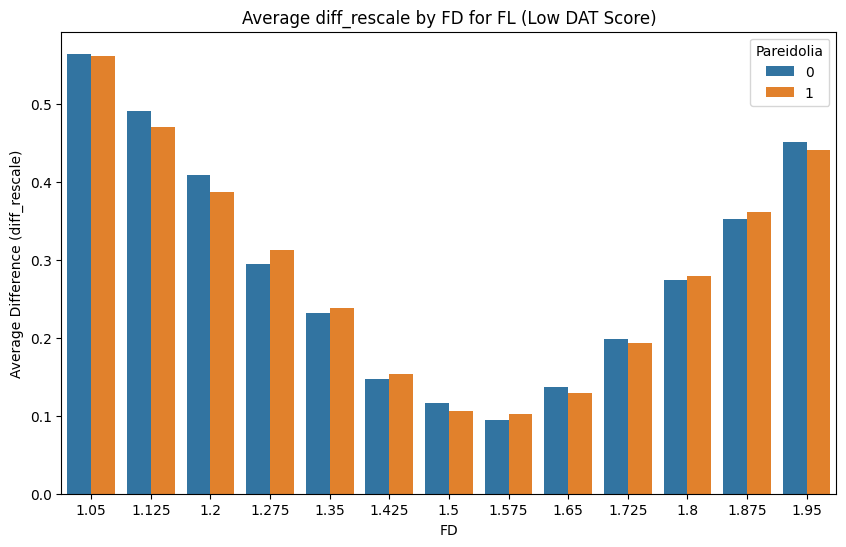

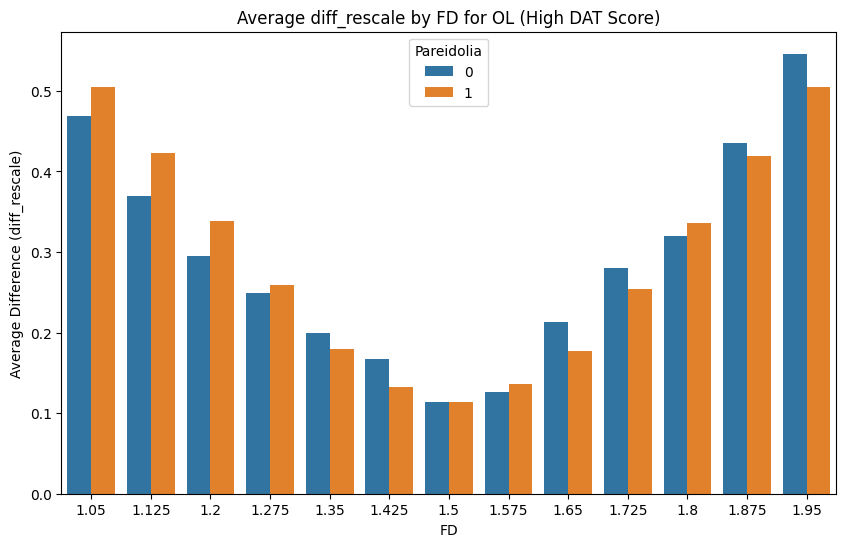

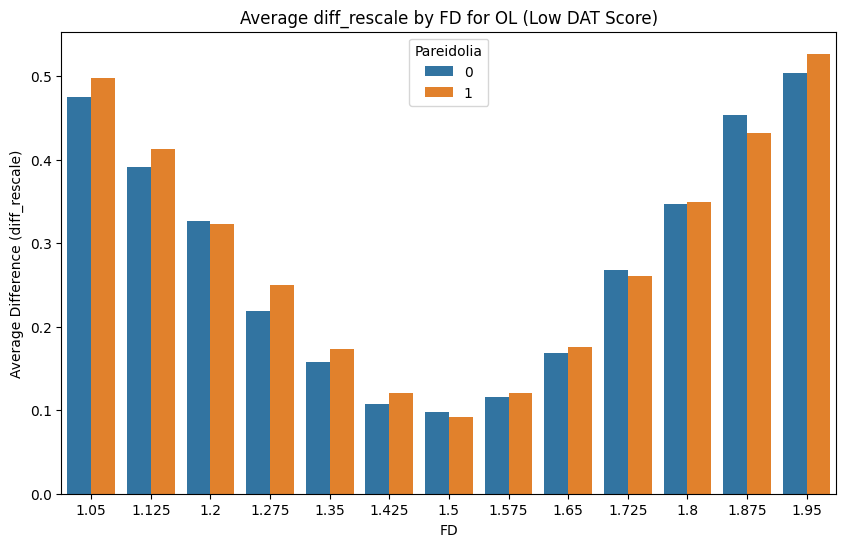

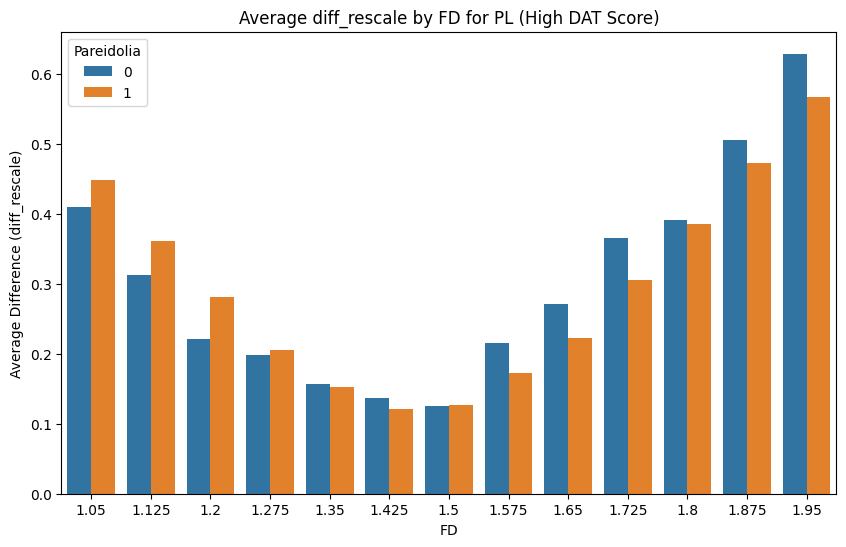

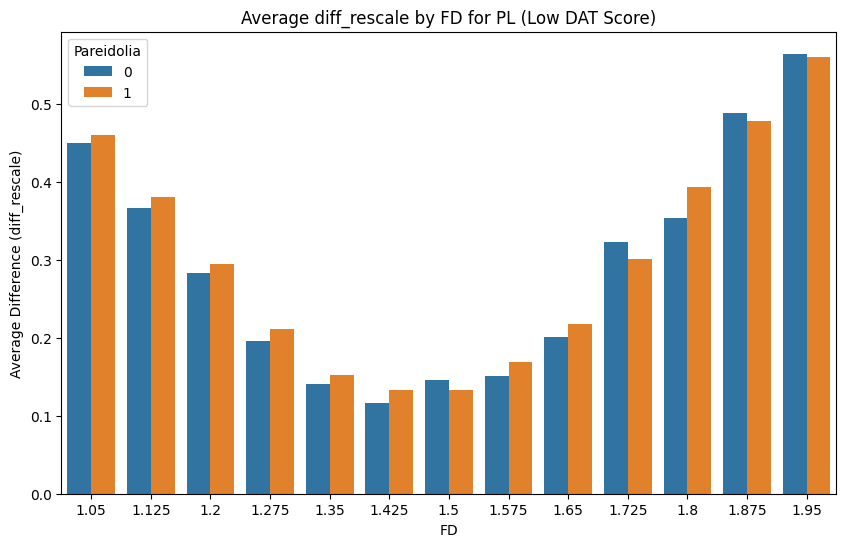

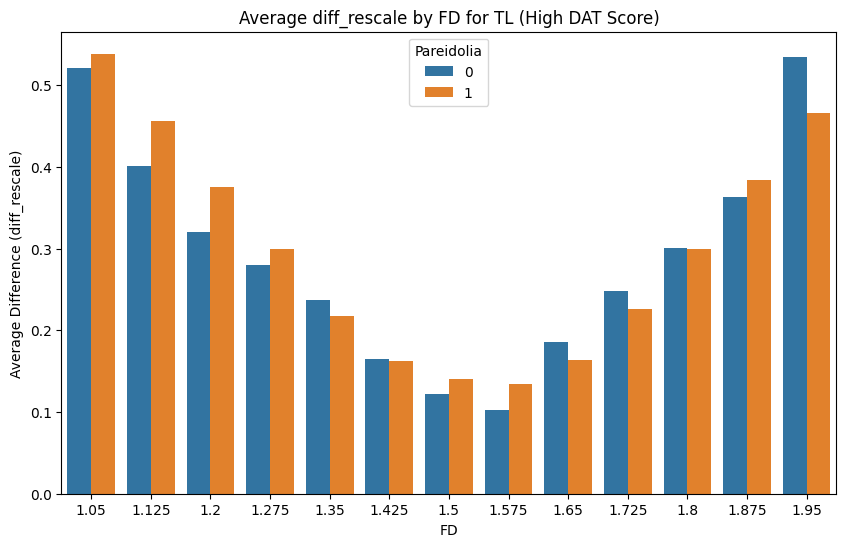

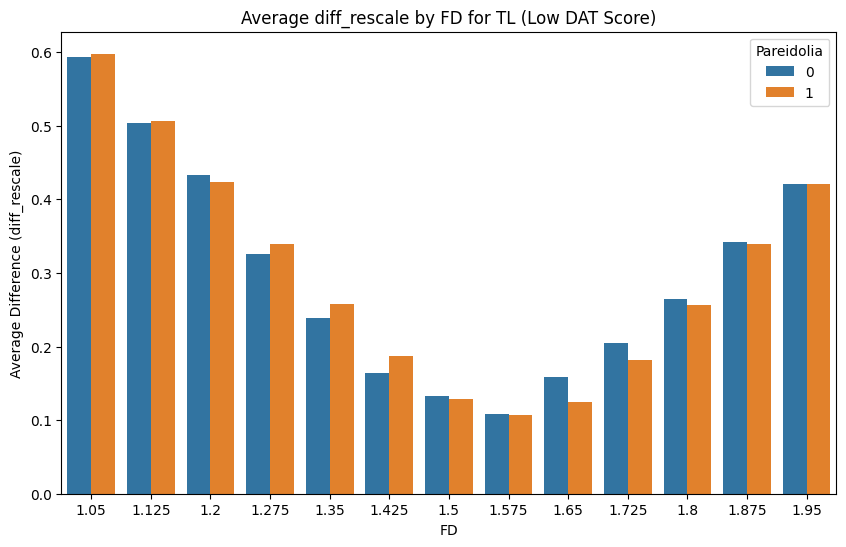

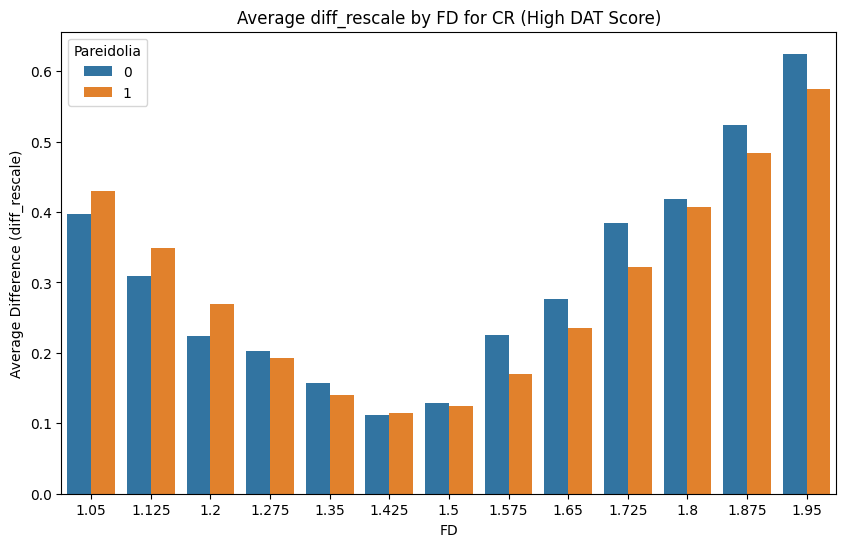

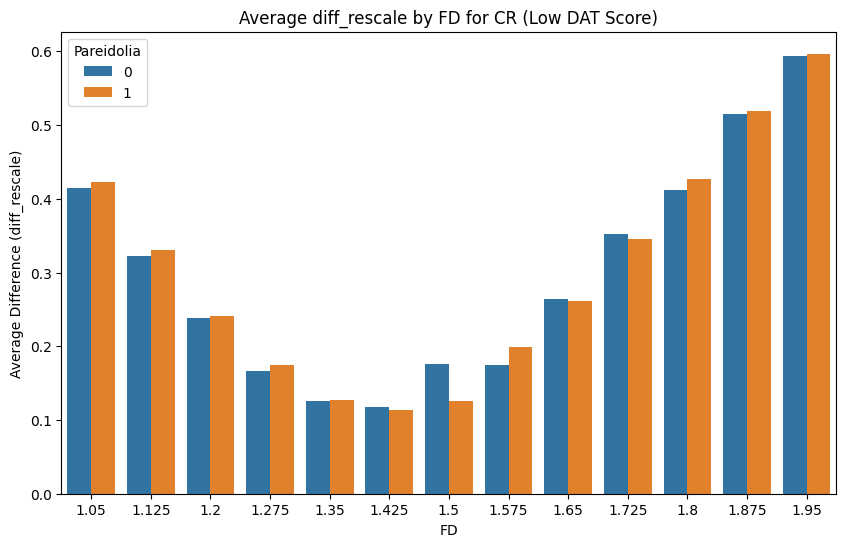

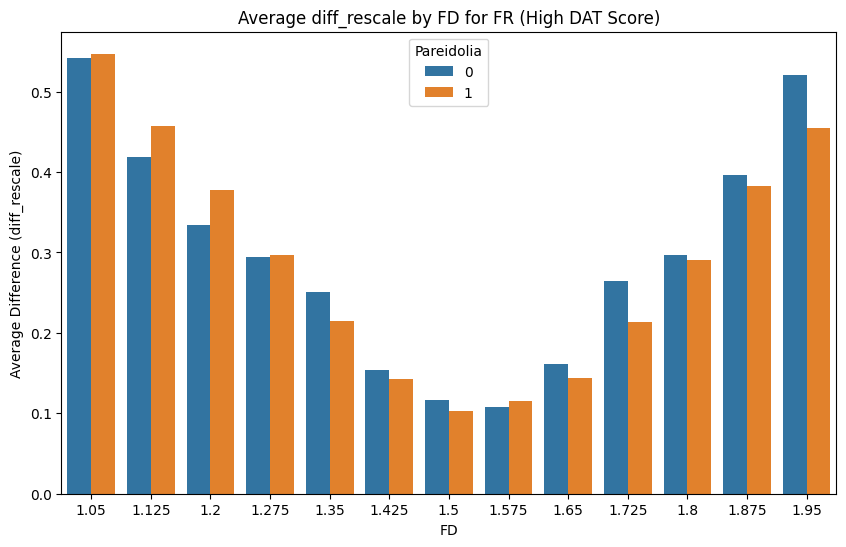

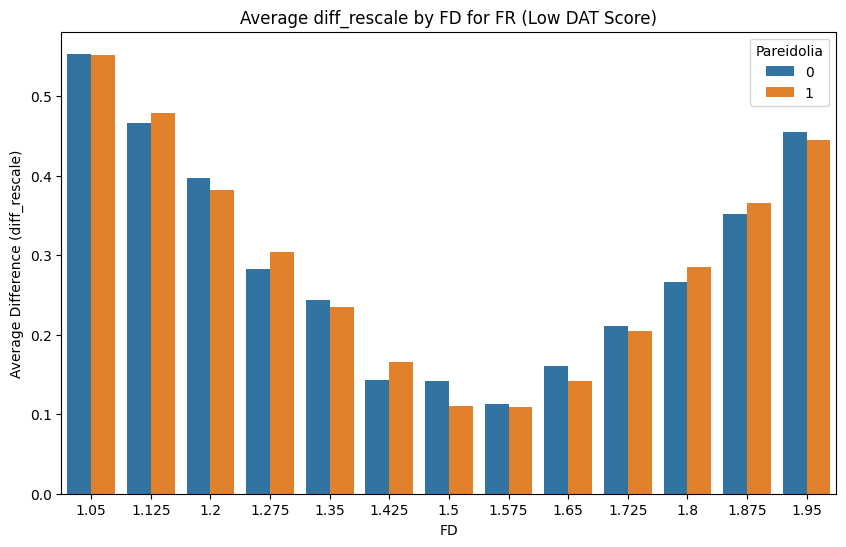

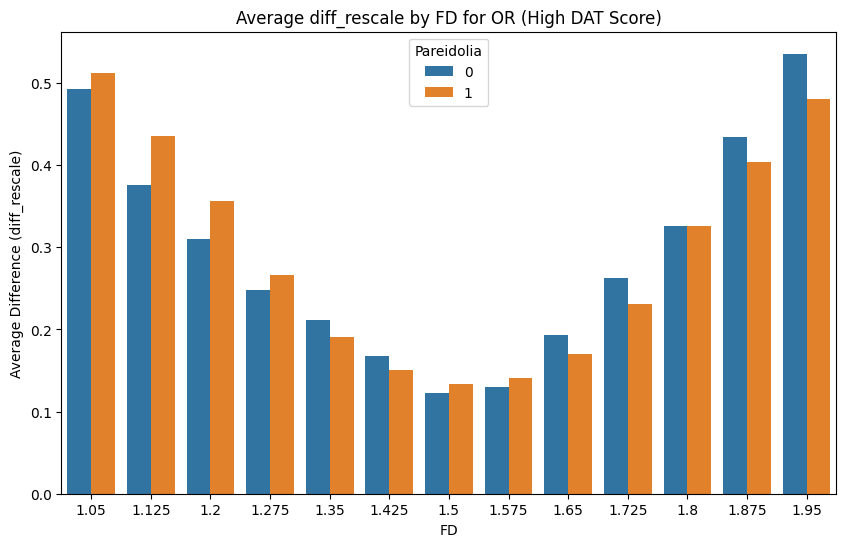

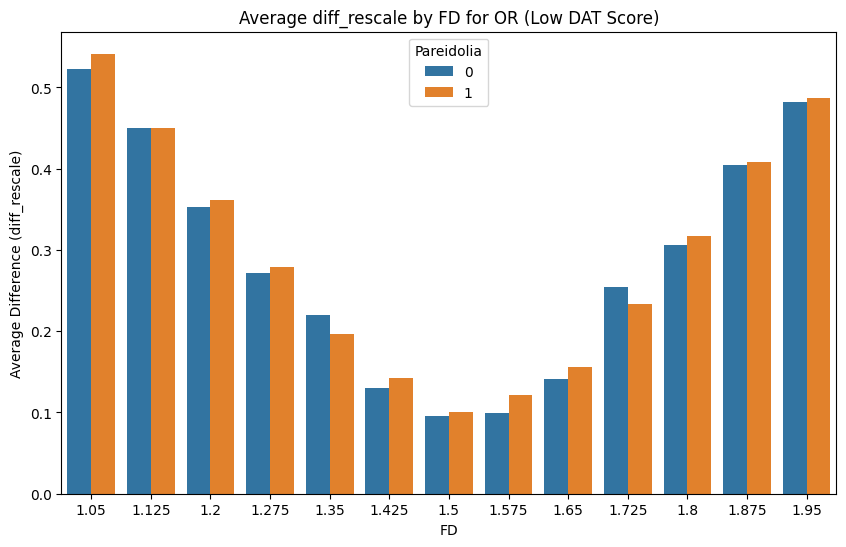

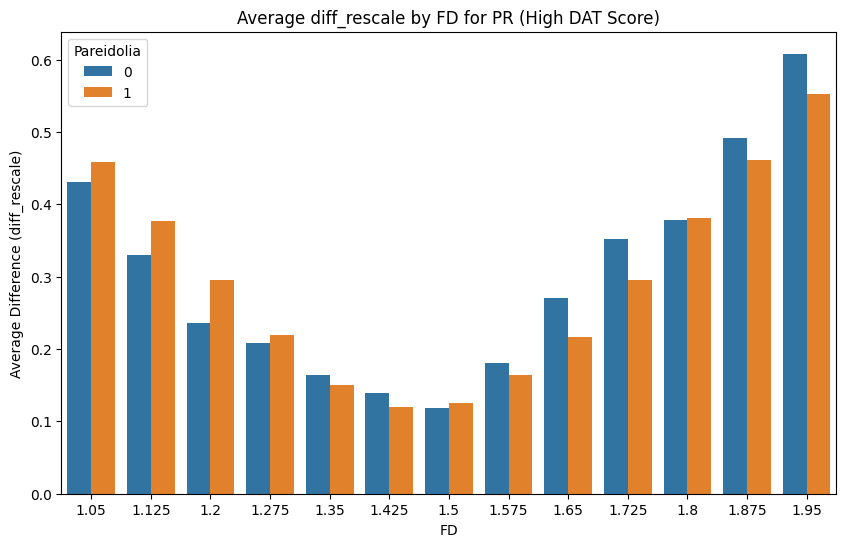

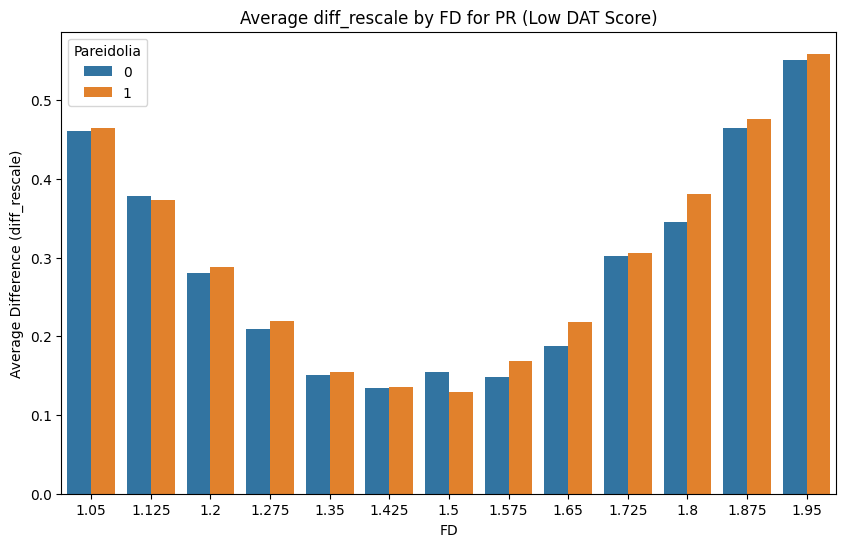

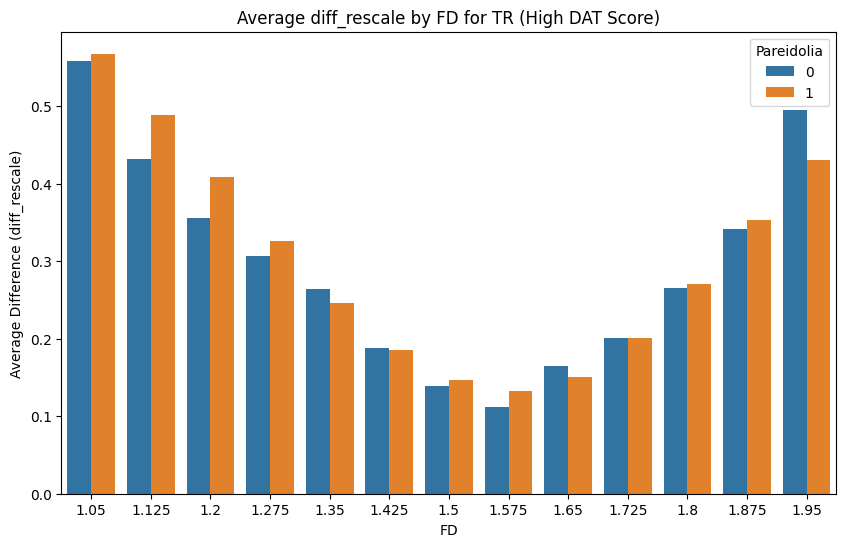

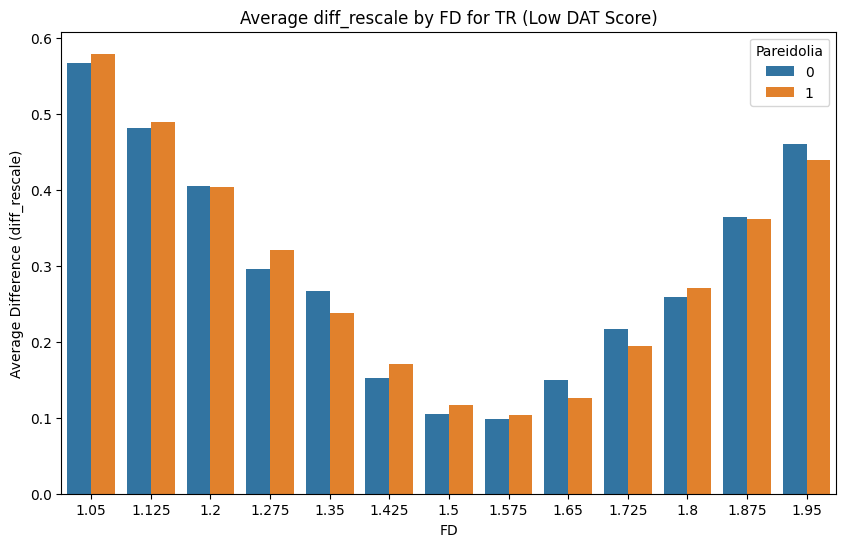

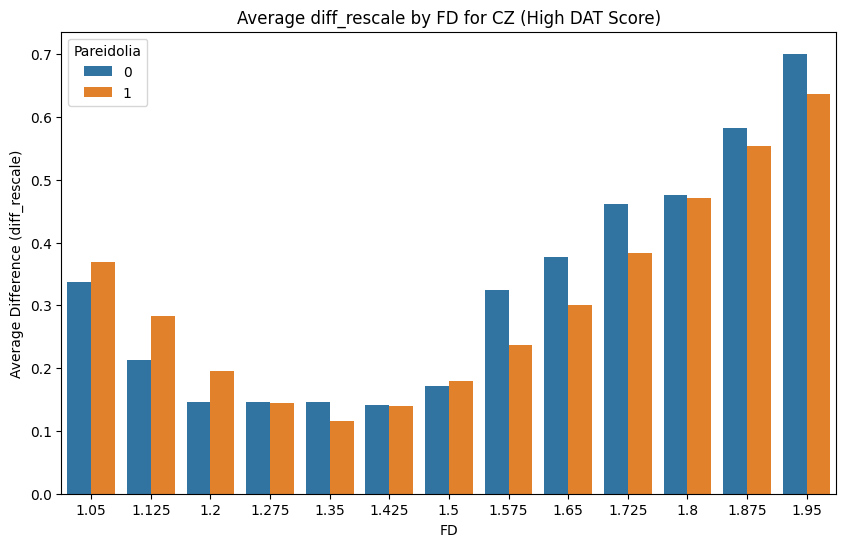

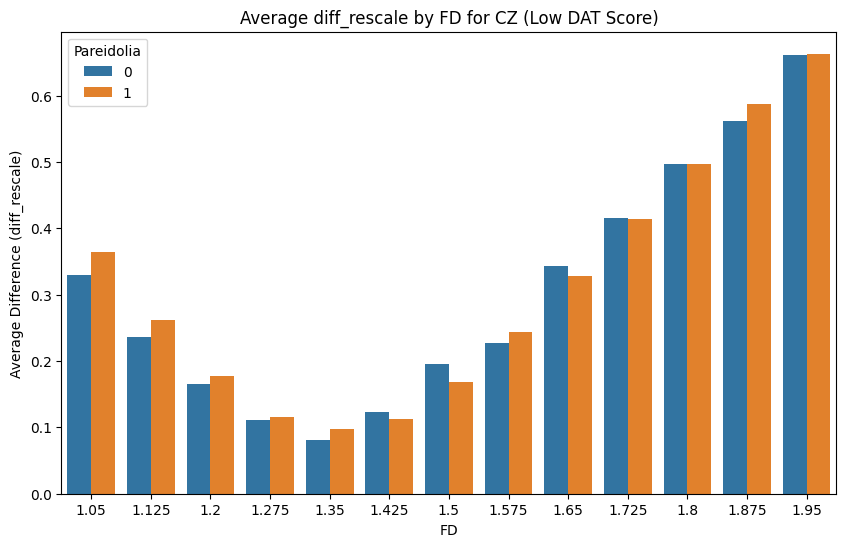

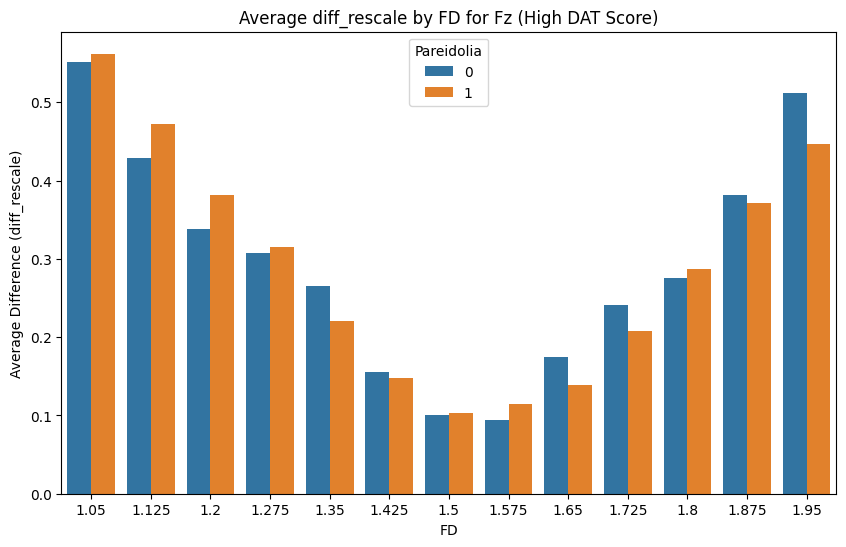

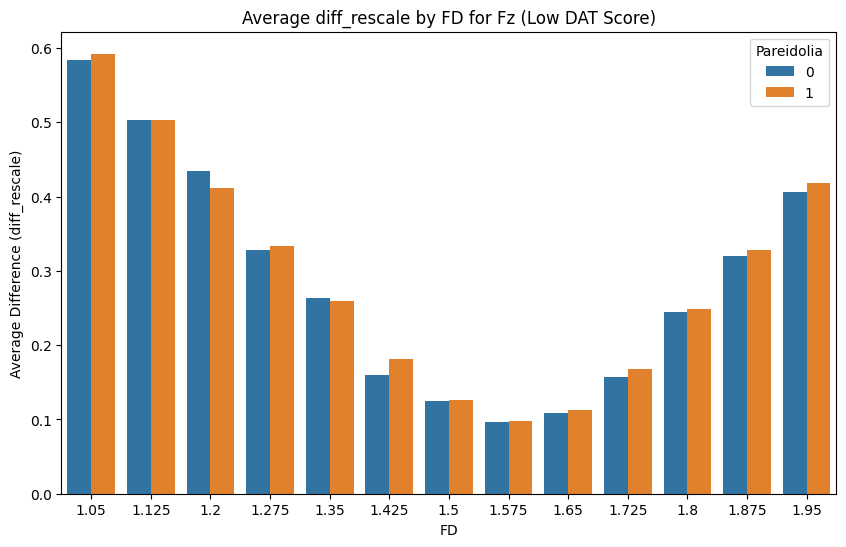

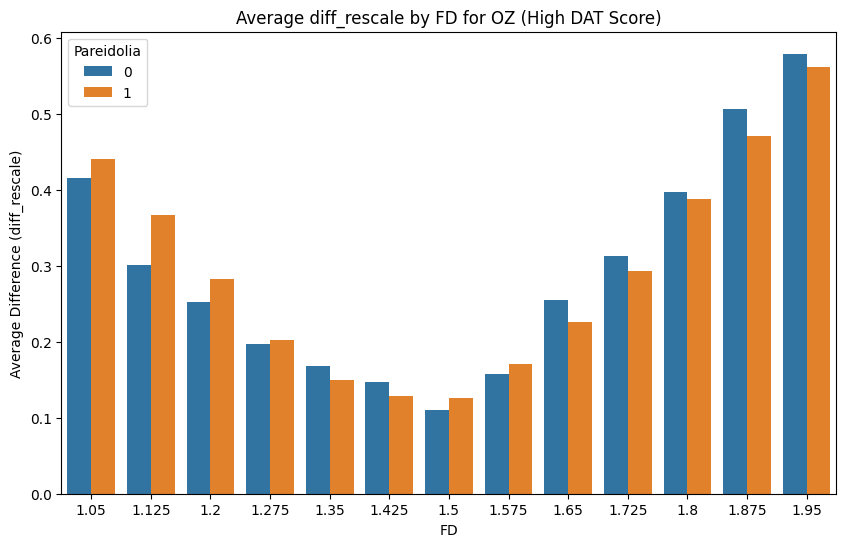

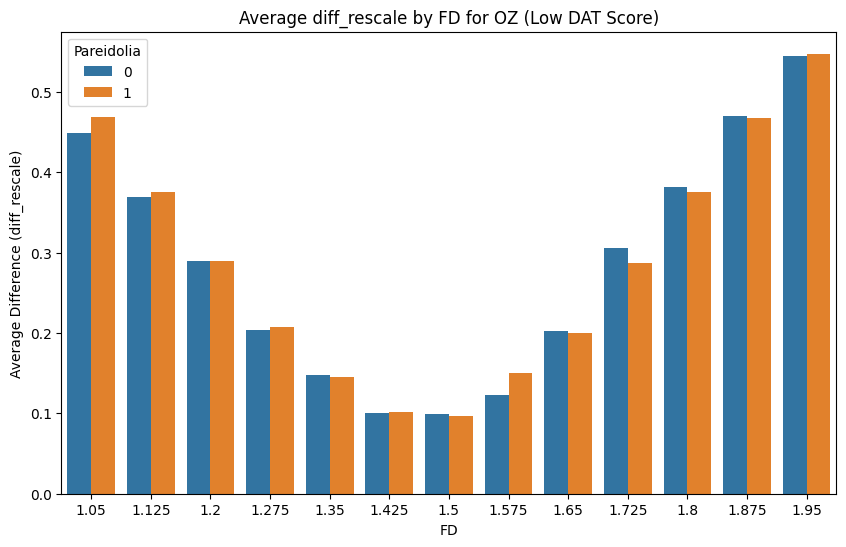

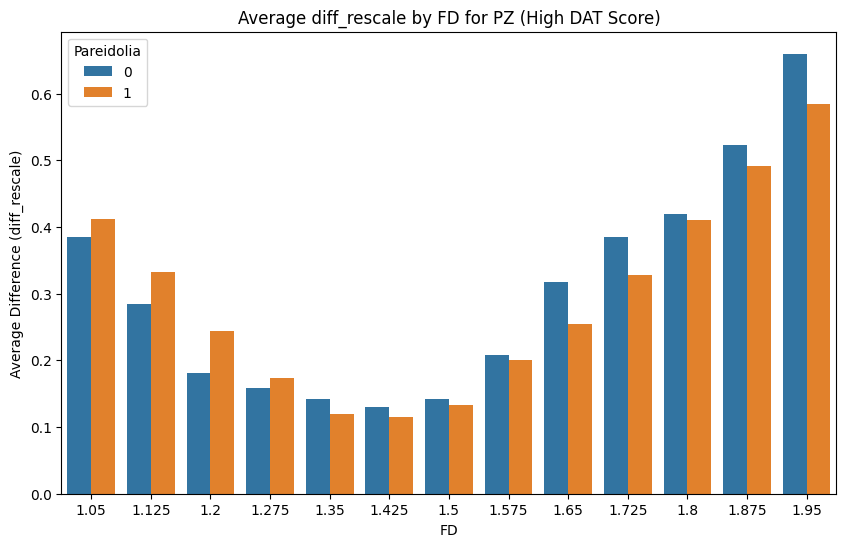

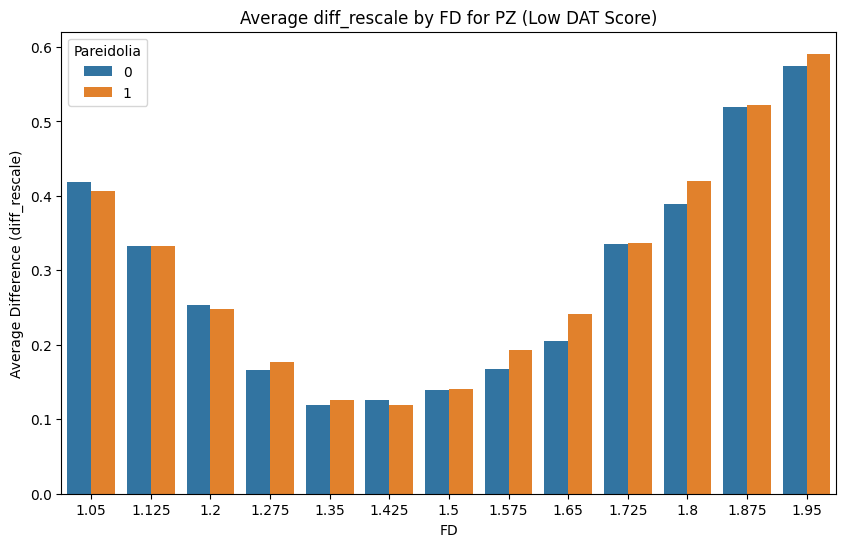

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# Assuming 'DAT' scores and 'brain_region' are in the dataframe 'df'
median_DAT = df['DAT'].median()


df['brain_region'] = df['electrodes'].apply(lambda x: map_electrode_to_region(x, MEG_atlas))
brain_regions = df['brain_region'].unique()

avg_diff_by_FD_parei = df.groupby(['participant', 'FD', 'parei', 'brain_region'])['diff_rescale'].mean().reset_index()
# Function to plot data for a given set of participants and a specific brain region
def plot_diff_rescale_for_region(participants_set, brain_region, title_suffix):
    # Filter data for the current set of participants and brain region
    avg_diff_subset = avg_diff_by_FD_parei[(avg_diff_by_FD_parei['participant'].isin(participants_set)) &
                                           (avg_diff_by_FD_parei['brain_region'] == brain_region)]
    overall_avg_diff_subset = avg_diff_subset.groupby(['FD', 'parei'])['diff_rescale'].mean().reset_index()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(data=overall_avg_diff_subset, x='FD', y='diff_rescale', hue='parei')
    plt.title(f'Average diff_rescale by FD for {brain_region} ({title_suffix})')
    plt.xlabel('FD')
    plt.ylabel('Average Difference (diff_rescale)')
    plt.legend(title='Pareidolia')
    plt.show()

# Iterate through each brain region and plot for both high and low DAT participants
for region in brain_regions:
    # High DAT participants for the current region
    high_DAT_participants = df[(df['DAT'] >= median_DAT) & (df['brain_region'] == region)]['participant'].unique()
    plot_diff_rescale_for_region(high_DAT_participants, region, 'High DAT Score')
    
    # Low DAT participants for the current region
    low_DAT_participants = df[(df['DAT'] < median_DAT) & (df['brain_region'] == region)]['participant'].unique()
    plot_diff_rescale_for_region(low_DAT_participants, region, 'Low DAT Score')


In [37]:
high_DAT_df['FD'].unique()

array([1.85, 1.65, 1.05, 1.25, 1.45])

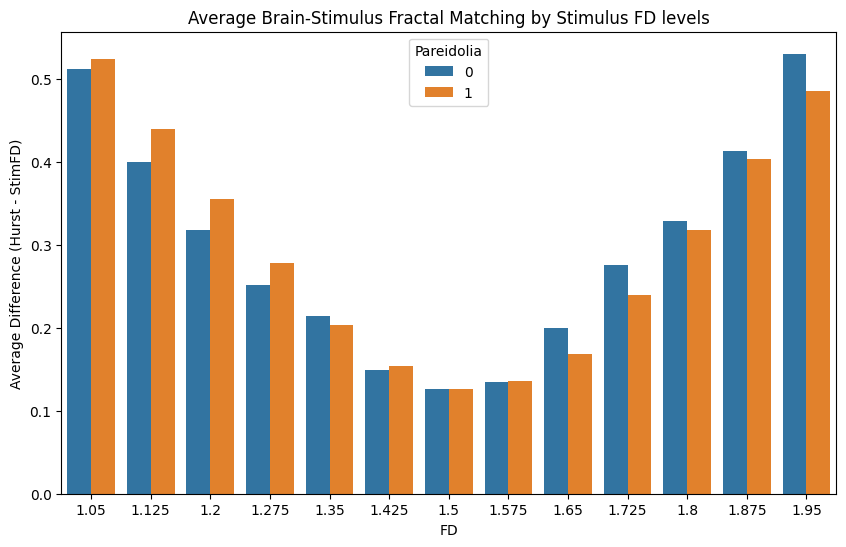

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# Average diff_rescale by participant, FD, and parei
avg_diff_by_FD_parei = df.groupby(['participant', 'FD', 'parei'])['diff_rescale'].mean().reset_index()

# Average diff_rescale by FD and parei across all participants
overall_avg_diff = avg_diff_by_FD_parei.groupby(['FD', 'parei'])['diff_rescale'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Creating bar plot
sns.barplot(data=overall_avg_diff, x='FD', y='diff_rescale', hue='parei')

# Preparing data for quadratic fit
parei_values = overall_avg_diff['parei'].unique()

plt.title('Average Brain-Stimulus Fractal Matching by Stimulus FD levels')
plt.xlabel('FD')
plt.ylabel('Average Difference (Hurst - StimFD)')
plt.legend(title='Pareidolia')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# Plotting
participants = avg_diff_by_FD_parei['participant'].unique()
for participant in participants:
    participant_data = avg_diff_by_FD_parei[avg_diff_by_FD_parei['participant'] == participant]
    plt.figure(figsize=(10, 6))
    sns.barplot(data=participant_data, x='FD', y='diff_rescale', hue='parei')
    plt.title(f'Average diff_rescale by FD for Participant {participant} (parei = 0 and 1)')
    plt.xlabel('FD')
    plt.ylabel('Average Difference (diff_rescale)')
    plt.show()


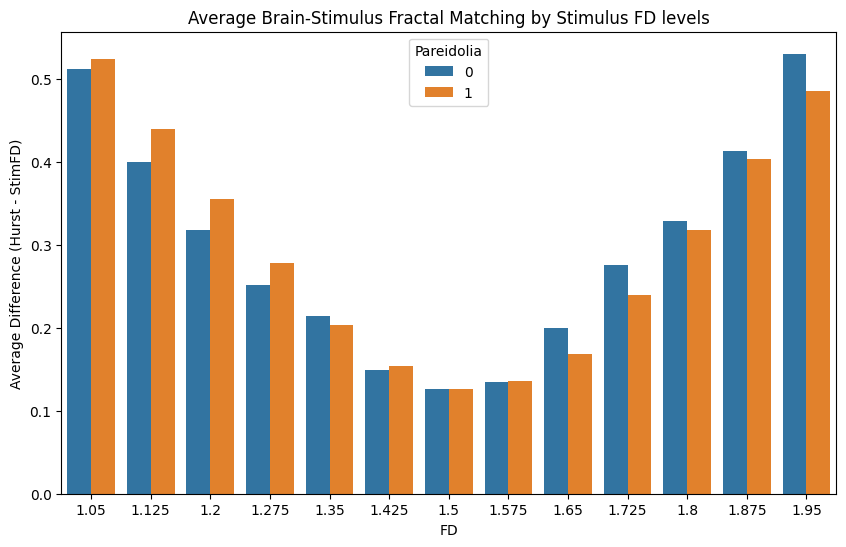

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit

# Average diff_rescale by FD and parei across all participants
overall_avg_diff = avg_diff_by_FD_parei.groupby(['FD', 'parei'])['diff_rescale'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Creating bar plot
sns.barplot(data=overall_avg_diff, x='FD', y='diff_rescale', hue='parei')

# Preparing data for quadratic fit
parei_values = overall_avg_diff['parei'].unique()

plt.title('Average Brain-Stimulus Fractal Matching by Stimulus FD levels')
plt.xlabel('FD')
plt.ylabel('Average Difference (Hurst - StimFD)')
plt.legend(title='Pareidolia')
plt.show()
